In [1]:
import json
from pathlib import Path
import os 
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import yaml
import re

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}


OOD_model_color_dict = {
    "Monge (1 cond.)": default_colors["wine"],
    "Identity": default_colors["sand"],
    "CMonge-Dose (3 cond.)": default_colors["indigo"],
    "CMonge-DrugDose-MoA (32 cond.)": default_colors["cyan"],
    "CMonge-DrugDose-RDkit (32 cond.)": default_colors["teal"],
    "Monge-Dose (3 cond.)": default_colors["rose"],
    "Monge-DrugDose (32 cond.)": default_colors["purple"],
    "chemCPA (32 cond.)": default_colors["green"],
    "CMonge-DrugDose-MoA (712 cond.)": default_colors["cyan"],
    "CMonge-DrugDose-RDkit (712 cond.)": default_colors["teal"],
    "chemCPA (712 cond.)": default_colors["green"],
}


rename_dict = {"Identity": "Identity", 
               "Monge": "Monge (1 cond.)", 
               "Monge-Dose": "Monge-Dose (3 cond.)", 
               "Monge-DrugDose": "Monge-DrugDose (32 cond.)", 
               "CMonge-Dose":  "CMonge-Dose (3 cond.)", 
               "CMonge-DrugDose-RDkit": "CMonge-DrugDose-RDkit (32 cond.)", 
               "CMonge-DrugDose-MoA": "CMonge-DrugDose-MoA (32 cond.)"}


In [3]:
BLACK = False 

if BLACK: 
    plt.style.use('dark_background')
else: 
    matplotlib.style.use("fivethirtyeight")
    matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
    sns.set_style("whitegrid")

matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 300
sns.set_context("poster")

# Baselines

## Monge model per condition

In [4]:
file_path = Path("/Users/alicedriessen/Box/otperturb/benedek-archive/ot-perturb/logs/cond/simple_monge_9_drugs.json")
leave = {"drug": [], "dose":[], "r2": [], "mmd":[], "wasserstein":[], "drug signature": [], "sinkhorn div": [],"model": []}
with open(file_path, "r") as file:
    cond = json.load(file)
for c in [10, 100, 1000, 10000]:
     for exp in cond["experiments"]:
          drug, dose = exp["drug"].split("-")
          if int(dose) == c:
               leave["mmd"].append(exp["mean_statistics"]["mean_mmd"])
               leave["wasserstein"].append(exp["mean_statistics"]["mean_wasserstein"])
               leave["r2"].append(exp["mean_statistics"]["mean_r2"])
               leave["drug signature"].append(exp["mean_statistics"]["mean_drug_signature"])
               leave["sinkhorn div"].append(exp["mean_statistics"]["mean_sinkhorn div"])
               leave["drug"].append(drug)
               leave["dose"].append(dose)
               leave["model"].append("Monge (1 cond.)")
monge_per_cond = pd.DataFrame(leave)
monge_per_cond["condition"] = monge_per_cond["drug"] + "-" + monge_per_cond["dose"].astype(str)


## Identity

In [5]:
file_path = Path("/Users/alicedriessen/Box/otperturb/benedek-archive/ot-perturb/logs/cond/simple_identity_9_drugs.json")
with open(file_path, "r") as file:
    ide = json.load(file)

data = {"drug":[], "model": [], "wasserstein":[], "mmd":[], "r2":[], "drug signature": [], "sinkhorn div": []}
exps = ide["experiments"] 
for exp in exps:
    data["drug"].append(exp["drug"])
    data["mmd"].append(exp["mean_statistics"]["mean_mmd"])
    data["wasserstein"].append(exp["mean_statistics"]["mean_wasserstein"])
    data["r2"].append(exp["mean_statistics"]["mean_r2"])
    data["drug signature"].append(exp["mean_statistics"]["mean_drug_signature"])
    data["sinkhorn div"].append(exp["mean_statistics"]["mean_sinkhorn div"])

data["model"] =  ["Identity"] * 36 
identity = pd.DataFrame(data)
identity["condition"] = identity["drug"]
identity[["drug", "dose"]] = [c.split("-") for c in identity["condition"]]

## Per drug and per dose results

In [6]:
dose_identity = identity.groupby(["dose", "model"]).mean(numeric_only=True).reset_index().replace(rename_dict)
drug_identity = identity.groupby(["drug", "model"]).mean(numeric_only=True).reset_index().replace(rename_dict)

dose_monge = monge_per_cond.groupby(["dose", "model"]).mean(numeric_only=True).reset_index().replace(rename_dict)
drug_monge = monge_per_cond.groupby(["drug", "model"]).mean(numeric_only=True).reset_index().replace(rename_dict)

monge_mean_r2 = monge_per_cond["r2"].mean()
identity_mean_r2 = identity["r2"].mean()

monge_mean_emd = monge_per_cond["wasserstein"].mean()
identity_mean_emd = identity["wasserstein"].mean()

monge_mean_mmd = monge_per_cond["mmd"].mean()
identity_mean_mmd = identity["mmd"].mean()


# Dose OOD

## Monge Dose OOD

In [7]:
drugs = ["abexinostat", "belinostat", "dacinostat", "entinostat", "givinostat", 
             "mocetinostat", "pracinostat", "tacedinaline", "trametinib"]
exp_order = ["homogenous_valid_set"]+ ["Monge-Dose (3 cond.)", "Identity", "within_condition"]
dosages=["-10", "-100", "-1000", "-10000"]

all_mean_metrics = []
for drug in drugs:
    for dose in dosages:

        with open(f"/Users/alicedriessen/Box/otperturb/alice_exp/sciplex_monge_dose_ood/{drug}{dose}/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
    
        print(drug, len(logs["experiments"]))
        for i, d in enumerate(logs["experiments"]):
        
            mean_stats = d["mean_statistics"]
            mean_stats = pd.DataFrame.from_dict(mean_stats, orient="index").T
            mean_stats["eval_setting"] = exp_order[i]
            mean_stats["ood_drug"] = f"{drug}{dose}"
            mean_stats["model"] = "Monge-Dose (3 cond.)"
            mean_stats["drug"] = drug
            mean_stats["dose"] = dose[1:]
            all_mean_metrics.append(mean_stats)
monge_dose_ood = pd.concat(all_mean_metrics).reset_index(drop=True)
monge_dose_ood = monge_dose_ood[monge_dose_ood["eval_setting"]=="Monge-Dose (3 cond.)"].reset_index(drop=True)
monge_dose_ood = monge_dose_ood.rename(columns={"mean_r2": "r2",
                                             "mean_wasserstein": "wasserstein"})

abexinostat 4
abexinostat 4
abexinostat 4
abexinostat 4
belinostat 4
belinostat 4
belinostat 4
belinostat 4
dacinostat 4
dacinostat 4
dacinostat 4
dacinostat 4
entinostat 4
entinostat 4
entinostat 4
entinostat 4
givinostat 4
givinostat 4
givinostat 4
givinostat 4
mocetinostat 4
mocetinostat 4
mocetinostat 4
mocetinostat 4
pracinostat 4
pracinostat 4
pracinostat 4
pracinostat 4
tacedinaline 4
tacedinaline 4
tacedinaline 4
tacedinaline 4
trametinib 4
trametinib 4
trametinib 4
trametinib 4


## CMonge dose OOD

In [8]:
file_path = Path("/Users/alicedriessen/Box/otperturb/benedek-archive/ot-perturb/logs/cond/conditional_monge_ood_9_drugs_NEW.json")
with open(file_path, "r") as file:
    ide = json.load(file)

data = {"drug":[], "model": [], "wasserstein":[], "mmd":[], "r2":[], "drug signature": [], "sinkhorn div": [], "dose": []}
exps = ide["experiments"] 
for exp_dict in exps:
    exp_key = [k for k in exp_dict.keys() if k.startswith("out-sample-")][0]
    exp = exp_dict[exp_key]
    data["drug"].append(exp["drug"])
    data["dose"].append(exp_key.split("-")[-1])
    data["mmd"].append(exp["mean_statistics"]["mean_mmd"])
    data["wasserstein"].append(exp["mean_statistics"]["mean_wasserstein"])
    data["r2"].append(exp["mean_statistics"]["mean_r2"])
    data["drug signature"].append(exp["mean_statistics"]["mean_drug_signature"])
    data["sinkhorn div"].append(exp["mean_statistics"]["mean_sinkhorn div"])

data["model"] =  ["CMonge-Dose (3 cond.)"] * 36 
cmonge_dose_ood = pd.DataFrame(data)
cmonge_dose_ood["condition"] = cmonge_dose_ood["drug"] + "-" + identity["dose"].astype(str)


# Drug Dose OOD

## Conditional Monge DrugDose OOD

In [9]:
drugs = ["abexinostat", "belinostat", "dacinostat", "entinostat", "givinostat", 
             "mocetinostat", "pracinostat", "tacedinaline", "trametinib"]
exp_order = ["homogenous_valid_set", "CMonge-DrugDose", "Identity", "within_condition", "within_condition", "within_condition", "within_condition"]

all_mean_metrics = []
for drug in drugs:
    for embedding in ["moa", "rdkit"]:

        with open(f"/Users/alicedriessen/Box/otperturb/alice_exp/sciplex_drug_ood/{embedding}/{drug}/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        
        if len(logs["experiments"])>7:
            logs["experiments"]=logs["experiments"][-7:]
       
        print(drug, embedding, len(logs["experiments"]))
        for i in range(len(logs["experiments"])):
            mean_stats = {k: v["mean_statistics"] for k, v in logs["experiments"][i]["valid-set"].items()}
            mean_stats = pd.DataFrame(mean_stats).T
            mean_stats["eval_setting"] = exp_order[i]
            mean_stats["ood_drug"] = drug
            mean_stats["embedding"] = embedding
            all_mean_metrics.append(mean_stats)
cmonge_ood_res = pd.concat(all_mean_metrics).reset_index().rename(columns={"index": "condition"})
cmonge_ood_res["dose"] = [cond.split("-")[1] for cond in cmonge_ood_res["condition"]]
cmonge_ood_res["drug"] = [cond.split("-")[0] for cond in cmonge_ood_res["condition"]]
cmonge_ood_res = cmonge_ood_res[cmonge_ood_res["eval_setting"]=="CMonge-DrugDose"]
cmonge_ood_res = cmonge_ood_res.rename(columns={"mean_r2": "r2",
                                             "mean_wasserstein": "wasserstein"})
cmonge_ood_res.loc[cmonge_ood_res["embedding"]=="moa", "model"] = "CMonge-DrugDose-MoA (32 cond.)"
cmonge_ood_res.loc[cmonge_ood_res["embedding"]=="rdkit", "model"] = "CMonge-DrugDose-RDkit (32 cond.)"
cmonge_ood_res

abexinostat moa 7
abexinostat rdkit 7
belinostat moa 7
belinostat rdkit 7
dacinostat moa 7
dacinostat rdkit 7
entinostat moa 7
entinostat rdkit 7
givinostat moa 7
givinostat rdkit 7
mocetinostat moa 7
mocetinostat rdkit 7
pracinostat moa 7
pracinostat rdkit 7
tacedinaline moa 7
tacedinaline rdkit 7
trametinib moa 7
trametinib rdkit 7


condition  wasserstein  mean_mmd  mean_sinkhorn div  \
32      abexinostat-10     2.769468  0.009932           2.196791   
33     abexinostat-100     2.568855  0.009617           1.998996   
34    abexinostat-1000     2.889745  0.012739           2.329269   
35   abexinostat-10000     3.404255  0.015594           2.849599   
76      abexinostat-10     6.863276  0.129214           6.290570   
..                 ...          ...       ...                ...   
739   trametinib-10000     3.562195  0.023369           3.011507   
780      trametinib-10     3.926643  0.023490           3.375155   
781     trametinib-100     3.865055  0.024113           3.311480   
782    trametinib-1000     3.947938  0.029876           3.391686   
783   trametinib-10000     4.045798  0.039389           3.495109   

     mean_monge_gap  mean_drug_signature        r2     eval_setting  \
32        13.237993             0.580370  0.860881  CMonge-DrugDose   
33        13.121056             0.418130  0.936327  CMonge-DrugDose   
34        13.137288             0.675845  0.931164  CMonge-DrugDose   
35        13.292877             0.819752  0.994683  CMonge-DrugDose   
76        12.654248             5.375520  0.105051  CMonge-DrugDose   
..              ...                  ...       ...              ...   
739       13.090679             1.267080  0.577290  CMonge-DrugDose   
780       13.249895             1.414531  0.485317  CMonge-DrugDose   
781       13.072442             1.368600  0.383006  CMonge-DrugDose   
782       13.014245             1.596595  0.267864  CMonge-DrugDose   
783       12.881466             1.814118  0.145315  CMonge-DrugDose   

        ood_drug embedding   dose         drug  \
32   abexinostat       moa     10  abexinostat   
33   abexinostat       moa    100  abexinostat   
34   abexinostat       moa   1000  abexinostat   
35   abexinostat       moa  10000  abexinostat   
76   abexinostat     rdkit     10  abexinostat   
..           ...       ...    ...          ...   
739   trametinib       moa  10000   trametinib   
780   trametinib     rdkit     10   trametinib   
781   trametinib     rdkit    100   trametinib   
782   trametinib     rdkit   1000   trametinib   
783   trametinib     rdkit  10000   trametinib   

                                model  
32     CMonge-DrugDose-MoA (32 cond.)  
33     CMonge-DrugDose-MoA (32 cond.)  
34     CMonge-DrugDose-MoA (32 cond.)  
35     CMonge-DrugDose-MoA (32 cond.)  
76   CMonge-DrugDose-RDkit (32 cond.)  
..                                ...  
739    CMonge-DrugDose-MoA (32 cond.)  
780  CMonge-DrugDose-RDkit (32 cond.)  
781  CMonge-DrugDose-RDkit (32 cond.)  
782  CMonge-DrugDose-RDkit (32 cond.)  
783  CMonge-DrugDose-RDkit (32 cond.)  

[72 rows x 13 columns]

## Monge DrugDose OOD

In [10]:
drugs = ["abexinostat", "belinostat", "dacinostat", "entinostat", "givinostat", 
             "mocetinostat", "pracinostat", "tacedinaline", "trametinib"]
exp_order = ["homogenous_valid_set"]+ ["Monge-DrugDose (32 cond.)", "Identity", "within_condition"] * 4
dosages=["-10", "-100", "-1000", "-10000"]

all_mean_metrics = []
for drug in drugs:

    with open(f"/Users/alicedriessen/Box/otperturb/alice_exp/sciplex_monge_ood/{drug}/logs.yaml") as stream:
        logs = yaml.safe_load(stream)

    print(drug, len(logs["experiments"]))
    for i, d in enumerate(logs["experiments"]):
        if i==0:
            continue
            
        mean_stats = d["mean_statistics"]
        mean_stats = pd.DataFrame.from_dict(mean_stats, orient="index").T
        mean_stats["eval_setting"] = exp_order[i]
        mean_stats["ood_drug"] = drug
        mean_stats["model"] = "Monge-DrugDose (32 cond.)"
        mean_stats["condition"] = drug+dosages[(i-1)%4]
        all_mean_metrics.append(mean_stats)
monge_ood_res = pd.concat(all_mean_metrics)
monge_ood_res[["drug", "dose"]] = [c.split("-") for c in monge_ood_res["condition"]]
monge_ood_res = monge_ood_res[monge_ood_res["eval_setting"]=="Monge-DrugDose (32 cond.)"].reset_index(drop=True)
monge_ood_res = monge_ood_res.rename(columns={"mean_r2": "r2",
                                             "mean_wasserstein": "wasserstein"})

abexinostat 13
belinostat 13
dacinostat 13
entinostat 13
givinostat 13
mocetinostat 13
pracinostat 13
tacedinaline 13
trametinib 13


## chemCPA results

In [11]:
with open("/Users/alicedriessen/Box/otperturb/alice_exp/chemCPA/chemCPA_on_cmonge_sciplex/1ood_train8_cmonge_eval.yaml", "r") as f:
    chemcpa = yaml.safe_load(f)

all_res = []
for drugdose in chemcpa.keys():
    res = chemcpa[drugdose]["mean_statistics"]
    res = pd.DataFrame.from_dict(res, orient="index").T
    res["drugdose"] = drugdose
    all_res.append(res)
chemCPA_ood = pd.concat(all_res).reset_index(drop=True)
chemCPA_ood[["drug", "dose"]] = [c.split("_") for c in chemCPA_ood['drugdose']]
chemCPA_ood["dose"] = (chemCPA_ood["dose"].astype(float) * 10000).astype(int).astype(str)
chemCPA_ood["model"] = "chemCPA (32 cond.)"
chemCPA_ood = chemCPA_ood.rename(columns={"mean_r2": "r2", "mean_wasserstein": "wasserstein"})

In [12]:
chemCPA_ood

mean_drug_signature  mean_mmd  mean_monge_gap        r2  \
0              1.004817  0.211786       12.808003  0.614843   
1              1.140481  0.217307       12.776778  0.526648   
2              2.471211  0.254050       12.622316  0.103938   
3              5.481746  0.388995       12.505316  0.094056   
4              1.770253  0.229624       13.146818  0.573923   
5              1.848057  0.227854       13.129650  0.547339   
6              2.213756  0.240585       12.701885  0.147218   
7              4.324471  0.370920       12.517275  0.390487   
8              1.058894  0.208885       12.669387  0.530448   
9              1.797563  0.226905       12.591646  0.117279   
10             4.902588  0.317110       12.542750  0.010187   
11             7.365469  0.420690       12.500344  0.008112   
12             0.801373  0.207235       13.174101  0.830152   
13             1.114462  0.210846       13.055982  0.727581   
14             1.305095  0.222081       13.036484  0.686651   
15             3.431093  0.301268       12.589153  0.419819   
16             1.027667  0.197431       13.174572  0.815487   
17             1.008006  0.197908       13.255783  0.826421   
18             1.236415  0.205154       13.215123  0.787442   
19             7.004779  0.360892       12.580818  0.000532   
20             2.283223  0.240654       13.727629  0.873477   
21             2.421716  0.239951       13.727551  0.835508   
22             2.644995  0.242729       13.618202  0.784351   
23             2.780795  0.257073       12.996606  0.122020   
24             0.874329  0.218692       12.748714  0.729027   
25             1.046243  0.222522       12.736201  0.620353   
26             1.826084  0.255131       12.584643  0.365526   
27             6.477822  0.403555       12.505889  0.081582   
28             1.334218  0.205115       13.437972  0.661879   
29             1.373659  0.210105       13.473509  0.651284   
30             1.397346  0.211603       13.533025  0.665383   
31             2.326373  0.227027       13.289844  0.509279   
32             1.727920  0.218189       12.967165  0.267483   
33             1.664473  0.215558       12.956972  0.288269   
34             1.612954  0.214766       12.923430  0.312904   
35             1.463226  0.214623       12.753324  0.271899   

    mean_sinkhorn div  wasserstein            drugdose          drug   dose  \
0            3.874540     4.334705   Abexinostat_0.001   Abexinostat     10   
1            4.076596     4.539124    Abexinostat_0.01   Abexinostat    100   
2            5.449445     5.912303     Abexinostat_0.1   Abexinostat   1000   
3            7.877804     8.353498     Abexinostat_1.0   Abexinostat  10000   
4            4.856923     5.323081    Belinostat_0.001    Belinostat     10   
5            4.864925     5.334448     Belinostat_0.01    Belinostat    100   
6            5.053680     5.546290      Belinostat_0.1    Belinostat   1000   
7            7.159324     7.628425      Belinostat_1.0    Belinostat  10000   
8            3.676905     4.103747    Dacinostat_0.001    Dacinostat     10   
9            4.386387     4.813991     Dacinostat_0.01    Dacinostat    100   
10           7.263677     7.691006      Dacinostat_0.1    Dacinostat   1000   
11           9.261955     9.709132      Dacinostat_1.0    Dacinostat  10000   
12           4.099916     4.546495    Entinostat_0.001    Entinostat     10   
13           4.185733     4.630169     Entinostat_0.01    Entinostat    100   
14           4.643637     5.090491      Entinostat_0.1    Entinostat   1000   
15           6.241448     6.697776      Entinostat_1.0    Entinostat  10000   
16           3.728161     4.177619    Givinostat_0.001    Givinostat     10   
17           3.692816     4.143601     Givinostat_0.01    Givinostat    100   
18           4.028574     4.479582      Givinostat_0.1    Givinostat   1000   
19           9.255736     9.703605      Givinostat_1.0    Givinostat  10000   
20           

In [13]:
chemCPA_ood

mean_drug_signature  mean_mmd  mean_monge_gap        r2  \
0              1.004817  0.211786       12.808003  0.614843   
1              1.140481  0.217307       12.776778  0.526648   
2              2.471211  0.254050       12.622316  0.103938   
3              5.481746  0.388995       12.505316  0.094056   
4              1.770253  0.229624       13.146818  0.573923   
5              1.848057  0.227854       13.129650  0.547339   
6              2.213756  0.240585       12.701885  0.147218   
7              4.324471  0.370920       12.517275  0.390487   
8              1.058894  0.208885       12.669387  0.530448   
9              1.797563  0.226905       12.591646  0.117279   
10             4.902588  0.317110       12.542750  0.010187   
11             7.365469  0.420690       12.500344  0.008112   
12             0.801373  0.207235       13.174101  0.830152   
13             1.114462  0.210846       13.055982  0.727581   
14             1.305095  0.222081       13.036484  0.686651   
15             3.431093  0.301268       12.589153  0.419819   
16             1.027667  0.197431       13.174572  0.815487   
17             1.008006  0.197908       13.255783  0.826421   
18             1.236415  0.205154       13.215123  0.787442   
19             7.004779  0.360892       12.580818  0.000532   
20             2.283223  0.240654       13.727629  0.873477   
21             2.421716  0.239951       13.727551  0.835508   
22             2.644995  0.242729       13.618202  0.784351   
23             2.780795  0.257073       12.996606  0.122020   
24             0.874329  0.218692       12.748714  0.729027   
25             1.046243  0.222522       12.736201  0.620353   
26             1.826084  0.255131       12.584643  0.365526   
27             6.477822  0.403555       12.505889  0.081582   
28             1.334218  0.205115       13.437972  0.661879   
29             1.373659  0.210105       13.473509  0.651284   
30             1.397346  0.211603       13.533025  0.665383   
31             2.326373  0.227027       13.289844  0.509279   
32             1.727920  0.218189       12.967165  0.267483   
33             1.664473  0.215558       12.956972  0.288269   
34             1.612954  0.214766       12.923430  0.312904   
35             1.463226  0.214623       12.753324  0.271899   

    mean_sinkhorn div  wasserstein            drugdose          drug   dose  \
0            3.874540     4.334705   Abexinostat_0.001   Abexinostat     10   
1            4.076596     4.539124    Abexinostat_0.01   Abexinostat    100   
2            5.449445     5.912303     Abexinostat_0.1   Abexinostat   1000   
3            7.877804     8.353498     Abexinostat_1.0   Abexinostat  10000   
4            4.856923     5.323081    Belinostat_0.001    Belinostat     10   
5            4.864925     5.334448     Belinostat_0.01    Belinostat    100   
6            5.053680     5.546290      Belinostat_0.1    Belinostat   1000   
7            7.159324     7.628425      Belinostat_1.0    Belinostat  10000   
8            3.676905     4.103747    Dacinostat_0.001    Dacinostat     10   
9            4.386387     4.813991     Dacinostat_0.01    Dacinostat    100   
10           7.263677     7.691006      Dacinostat_0.1    Dacinostat   1000   
11           9.261955     9.709132      Dacinostat_1.0    Dacinostat  10000   
12           4.099916     4.546495    Entinostat_0.001    Entinostat     10   
13           4.185733     4.630169     Entinostat_0.01    Entinostat    100   
14           4.643637     5.090491      Entinostat_0.1    Entinostat   1000   
15           6.241448     6.697776      Entinostat_1.0    Entinostat  10000   
16           3.728161     4.177619    Givinostat_0.001    Givinostat     10   
17           3.692816     4.143601     Givinostat_0.01    Givinostat    100   
18           4.028574     4.479582      Givinostat_0.1    Givinostat   1000   
19           9.255736     9.703605      Givinostat_1.0    Givinostat  10000   
20           

## Large DrugDose OOD results

### CMonge DrugDose large OOD

In [14]:
# all_mean_metrics = []

# for embedding in ["moa", "rdkit"]:
#     res_files = [str(f.absolute()) for f in pathlib.Path(f"/Users/alicedriessen/Box/otperturb/alice_exp/sciplex_5perc_ood/{embedding}/").glob("*_ood/results.yaml")]
#     for file in res_files:
#         split_name = file.split("/")[-2]
#         print(embedding, split_name)
#         with open(file) as stream:
#             logs = yaml.safe_load(stream)
        
#         mean_stats = {k: v["mean_statistics"] for k, v in logs["experiments"][0]["valid-set"].items()}
#         mean_stats = pd.DataFrame(mean_stats).T
       
#         mean_stats["model"] = "CMonge-DrugDose-OOD"
#         mean_stats["embedding"] = embedding
#         mean_stats["split_name"] = split_name
#         all_mean_metrics.append(mean_stats)
# big_res = pd.concat(all_mean_metrics)
# big_res[["drug", "dose"]] = [i.split("-") for i in big_res.index]
# big_res.loc[(big_res["model"]=="CMonge-DrugDose-OOD")&(big_res["embedding"]=="rdkit"), "model"] = "CMonge-DrugDose-RDkit (712 cond.)"
# big_res.loc[(big_res["model"]=="CMonge-DrugDose-OOD")&(big_res["embedding"]=="moa"), "model"] = "CMonge-DrugDose-MoA (712 cond.)"
# big_res["n_cond"] = 712
# big_res["model_size"] = "600K"
# big_res.to_csv("/Users/alicedriessen/Box/otperturb/alice_exp/sciplex_5perc_ood/all_results.csv")

In [15]:
big_res = pd.read_csv("/Users/alicedriessen/Box/otperturb/alice_exp/sciplex_5perc_ood/all_results.csv", index_col=0)

### Large chemCPA OOD

In [16]:
with open("/Users/alicedriessen/Box/otperturb/alice_exp/chemCPA/chemCPA_on_cmonge_sciplex/5perc_ood/cmonge_eval_drugdose.yaml") as f:
    logs = yaml.safe_load(f)
all_res = []
for drugdose in logs.keys():
    res = logs[drugdose]["mean_statistics"]
    res = pd.DataFrame.from_dict(res, orient="index").T
    res["drugdose"] = drugdose
    all_res.append(res)
big_chemcpa_res = pd.concat(all_res).reset_index()
big_chemcpa_res[["drug", "dose"]] = [c.split("_") for c in big_chemcpa_res['drugdose']]
big_chemcpa_res["dose"] = (big_chemcpa_res["dose"].astype(float) * 10000).astype(int).astype(str)
big_chemcpa_res["n_cond"] = 712
big_chemcpa_res["model_size"] = "1.4B"
big_chemcpa_res["embedding"] = "rdkit"
big_chemcpa_res["model"] = "chemCPA (712 cond.)"

# Small model results

In [17]:
small_OOD_res = pd.concat([identity, monge_per_cond, monge_ood_res, cmonge_ood_res, cmonge_dose_ood, monge_dose_ood, chemCPA_ood])
small_OOD_res = small_OOD_res.replace(rename_dict).reset_index(drop=True)
small_OOD_res

drug               model  wasserstein       mmd        r2  \
0     abexinostat            Identity     2.858245  0.016391  0.649924   
1     abexinostat            Identity     2.816926  0.014116  0.664775   
2     abexinostat            Identity     4.283113  0.066281  0.002521   
3     abexinostat            Identity     7.376582  0.184430  0.140207   
4      belinostat            Identity     3.574316  0.013262  0.721358   
..            ...                 ...          ...       ...       ...   
283  Tacedinaline  chemCPA (32 cond.)     5.790068       NaN  0.509279   
284    Trametinib  chemCPA (32 cond.)     4.517317       NaN  0.267483   
285    Trametinib  chemCPA (32 cond.)     4.426764       NaN  0.288269   
286    Trametinib  chemCPA (32 cond.)     4.395974       NaN  0.312904   
287    Trametinib  chemCPA (32 cond.)     4.214030       NaN  0.271899   

     drug signature  sinkhorn div          condition   dose  mean_mmd  \
0          1.022299      2.285513     abexinostat-10     10       NaN   
1          0.995097      2.247000    abexinostat-100    100       NaN   
2          2.699357      3.722621   abexinostat-1000   1000       NaN   
3          6.293126      6.821927  abexinostat-10000  10000       NaN   
4          1.307859      2.999984      belinostat-10     10       NaN   
..              ...           ...                ...    ...       ...   
283             NaN           NaN                NaN  10000  0.227027   
284             NaN           NaN                NaN     10  0.218189   
285             NaN           NaN                NaN    100  0.215558   
286             NaN           NaN                NaN   1000  0.214766   
287             NaN           NaN                NaN  10000  0.214623   

     mean_sinkhorn div  mean_monge_gap  mean_drug_signature eval_setting  \
0                  NaN             NaN                  NaN          NaN   
1                  NaN             NaN                  NaN          NaN   
2                  NaN             NaN                  NaN          NaN   
3                  NaN             NaN                  NaN          NaN   
4                  NaN             NaN                  NaN          NaN   
..                 ...             ...                  ...          ...   
283           5.321719       13.289844             2.326373          NaN   
284           4.094604       12.967165             1.727920          NaN   
285           4.004832       12.956972             1.664473          NaN   
286           3.972144       12.923430             1.612954          NaN   
287           3.783833       12.753324             1.463226          NaN   

    ood_drug embedding          drugdose  
0        NaN       NaN               NaN  
1        NaN       NaN               NaN  
2        NaN       NaN               NaN  
3        NaN       NaN               NaN  
4        NaN       NaN               NaN  
..       ...       ...               ...  
283      NaN       NaN  Tacedinaline_1.0  
284      NaN       NaN  Trametinib_0.001  
285      NaN       NaN   Trametinib_0.01  
286      NaN       NaN    Trametinib_0.1  
287      NaN       NaN    Trametinib_1.0  

[288 rows x 17 columns]

In [18]:
small_OOD_res["r2"].isna().sum()

0

In [19]:
small_OOD_res["wasserstein"].isna().sum() # No wasserstein for chemCPA: 3*9*4=108 rows

0

In [20]:
drugs = sorted(small_OOD_res["drug"].unique())
drug_order = [d.capitalize() for d in drugs]
hue_order = ["Monge-Dose (3 cond.)", "Monge-DrugDose (32 cond.)", 
             "CMonge-Dose (3 cond.)", "CMonge-DrugDose-RDkit (32 cond.)", "CMonge-DrugDose-MoA (32 cond.)",
            "chemCPA (32 cond.)"] 



In [21]:
small_OOD_res["model"].unique()

array(['Identity', 'Monge (1 cond.)', 'Monge-DrugDose (32 cond.)',
       'CMonge-DrugDose-MoA (32 cond.)',
       'CMonge-DrugDose-RDkit (32 cond.)', 'CMonge-Dose (3 cond.)',
       'Monge-Dose (3 cond.)', 'chemCPA (32 cond.)'], dtype=object)

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/3931174072.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(dose_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/3931174072.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(dose_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")


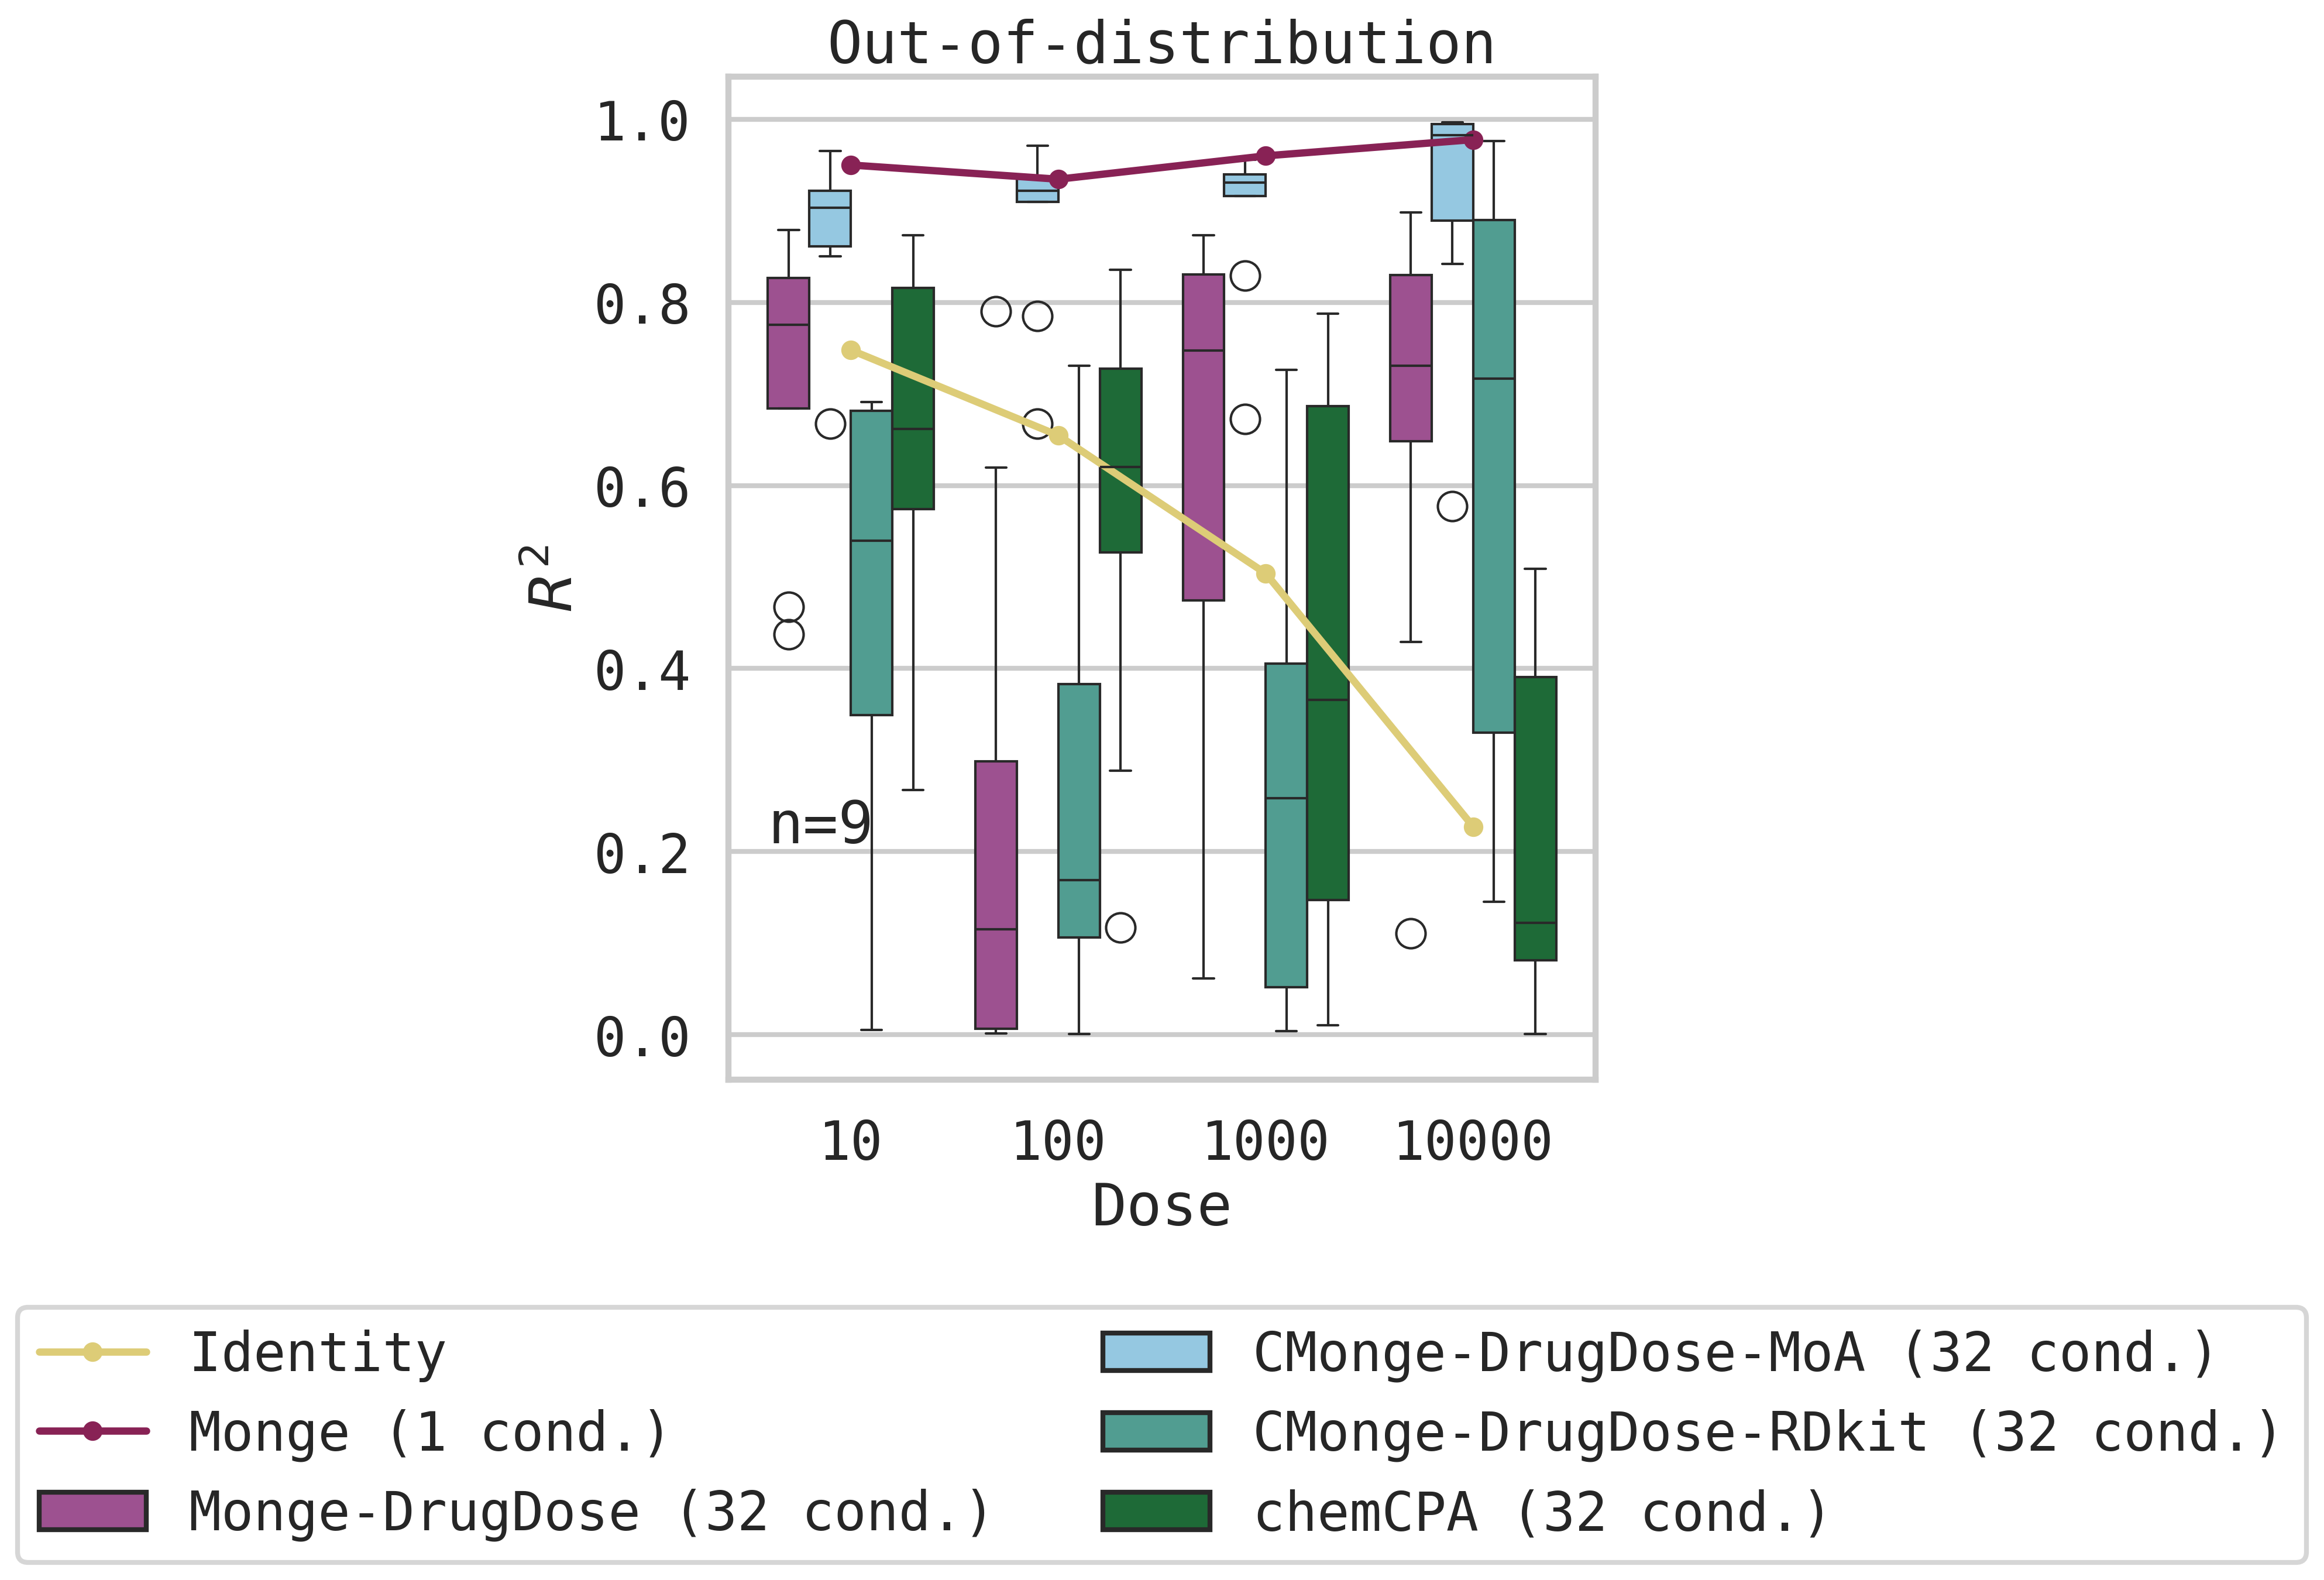

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

sns.boxplot(data=small_OOD_res, x="dose", y="r2", hue="model", palette=OOD_model_color_dict,
            hue_order=["Monge-DrugDose (32 cond.)", "CMonge-DrugDose-MoA (32 cond.)", "CMonge-DrugDose-RDkit (32 cond.)", "chemCPA (32 cond.)"], 
            ax=ax)

ax.plot(dose_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
ax.plot(dose_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")

plt.title("Out-of-distribution")
plt.ylabel("$R^2$")
plt.xlabel("Dose")

handles, labels = ax.get_legend_handles_labels()
order = [5, 4, 0, 1, 2, 3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="", ncols=2, bbox_to_anchor=(0.5, -0.2), loc="upper center")
# plt.legend(title="", ncols=2, bbox_to_anchor=(0.5, -0.2), loc="upper center")

plt.text(x=-0.4, y=0.21 , s="n=9")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_drugdose_OOD_legend.pdf", bbox_inches="tight")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1325143152.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=small_OOD_res, x="dose", y="r2", hue="model", palette=OOD_model_color_dict,
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1325143152.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(dose_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1325143152.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(dose_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, mar

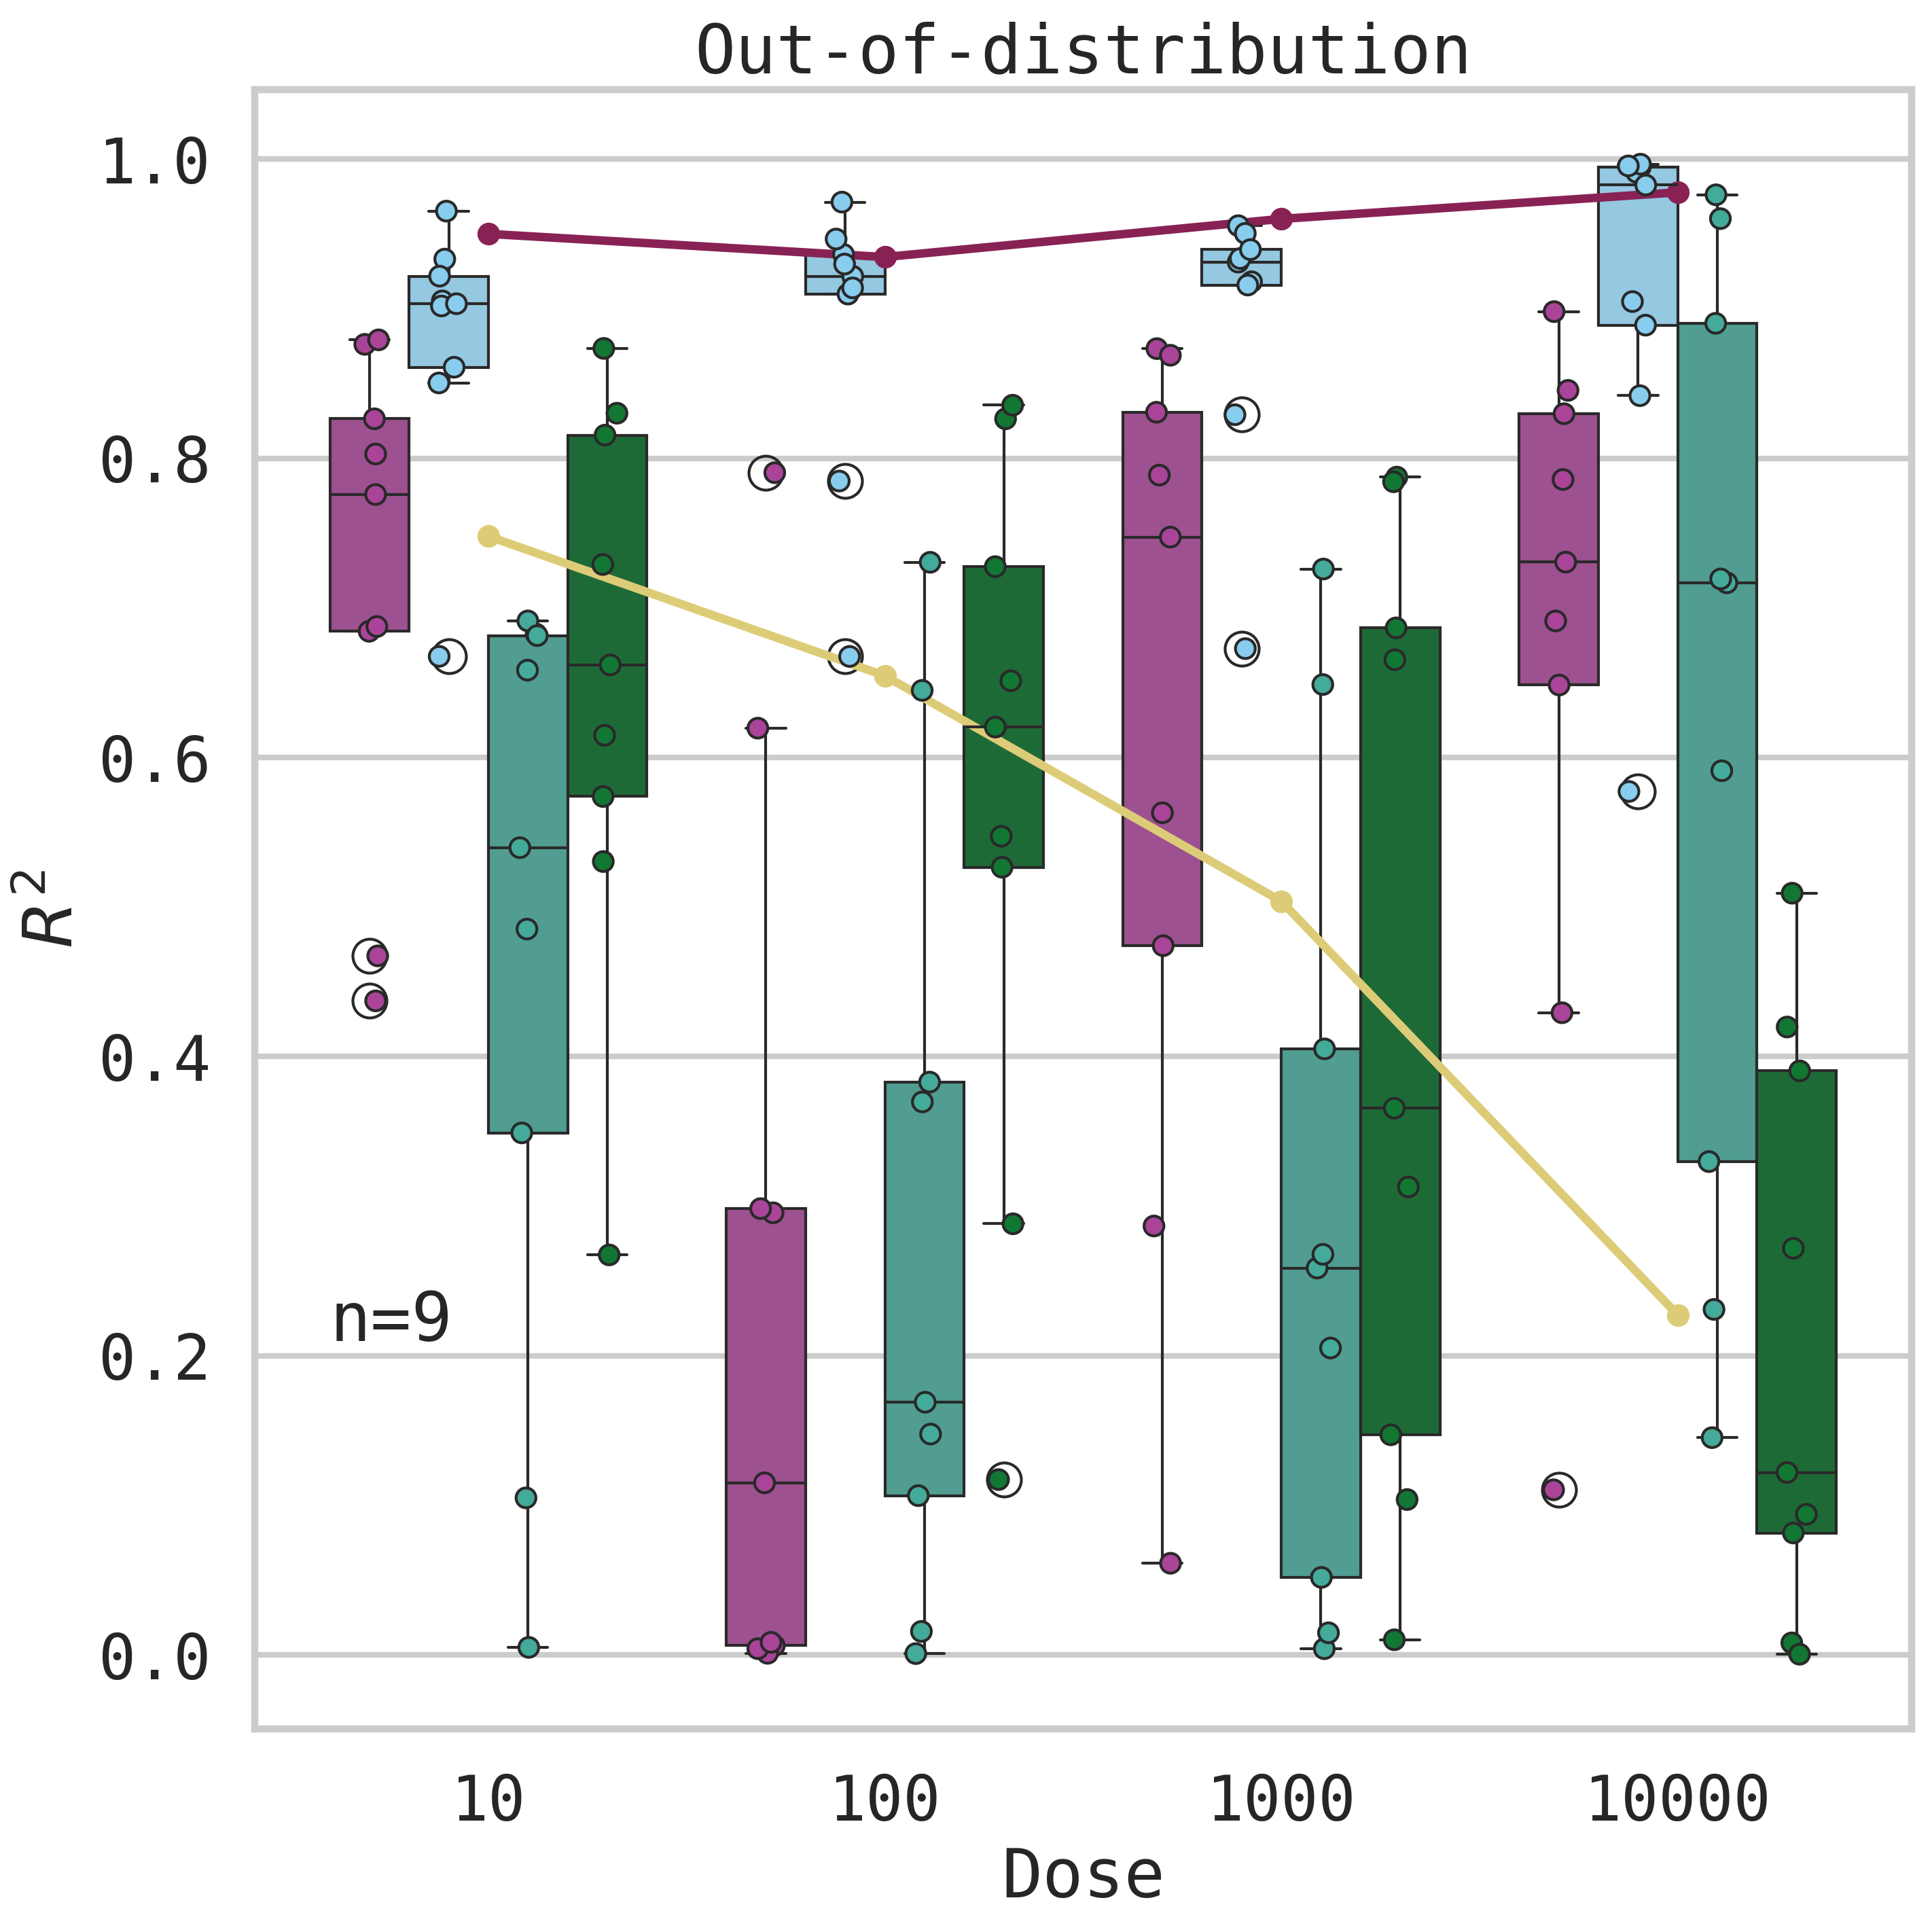

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

sns.boxplot(data=small_OOD_res, x="dose", y="r2", hue="model", palette=OOD_model_color_dict,
            hue_order=["Monge-DrugDose (32 cond.)", "CMonge-DrugDose-MoA (32 cond.)", "CMonge-DrugDose-RDkit (32 cond.)", "chemCPA (32 cond.)"], 
            ax=ax)
sns.stripplot(data=small_OOD_res, x="dose", y="r2", hue="model", palette=OOD_model_color_dict,
            hue_order=["Monge-DrugDose (32 cond.)", "CMonge-DrugDose-MoA (32 cond.)", "CMonge-DrugDose-RDkit (32 cond.)", "chemCPA (32 cond.)"], 
            ax=ax, linewidth=1, edgecolor="gray", dodge=True, s=7)

ax.plot(dose_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
ax.plot(dose_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")

plt.title("Out-of-distribution")
plt.ylabel("$R^2$")
plt.xlabel("Dose")

plt.legend("", frameon=False)

plt.text(x=-0.4, y=0.21 , s="n=9")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_drugdose_OOD_NoLegend.pdf", bbox_inches="tight")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1195155599.py:7: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(small_OOD_res, x="drug", y="r2", hue="model", ax=ax, dodge=0.6,
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1195155599.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(drug_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1195155599.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(drug_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label=

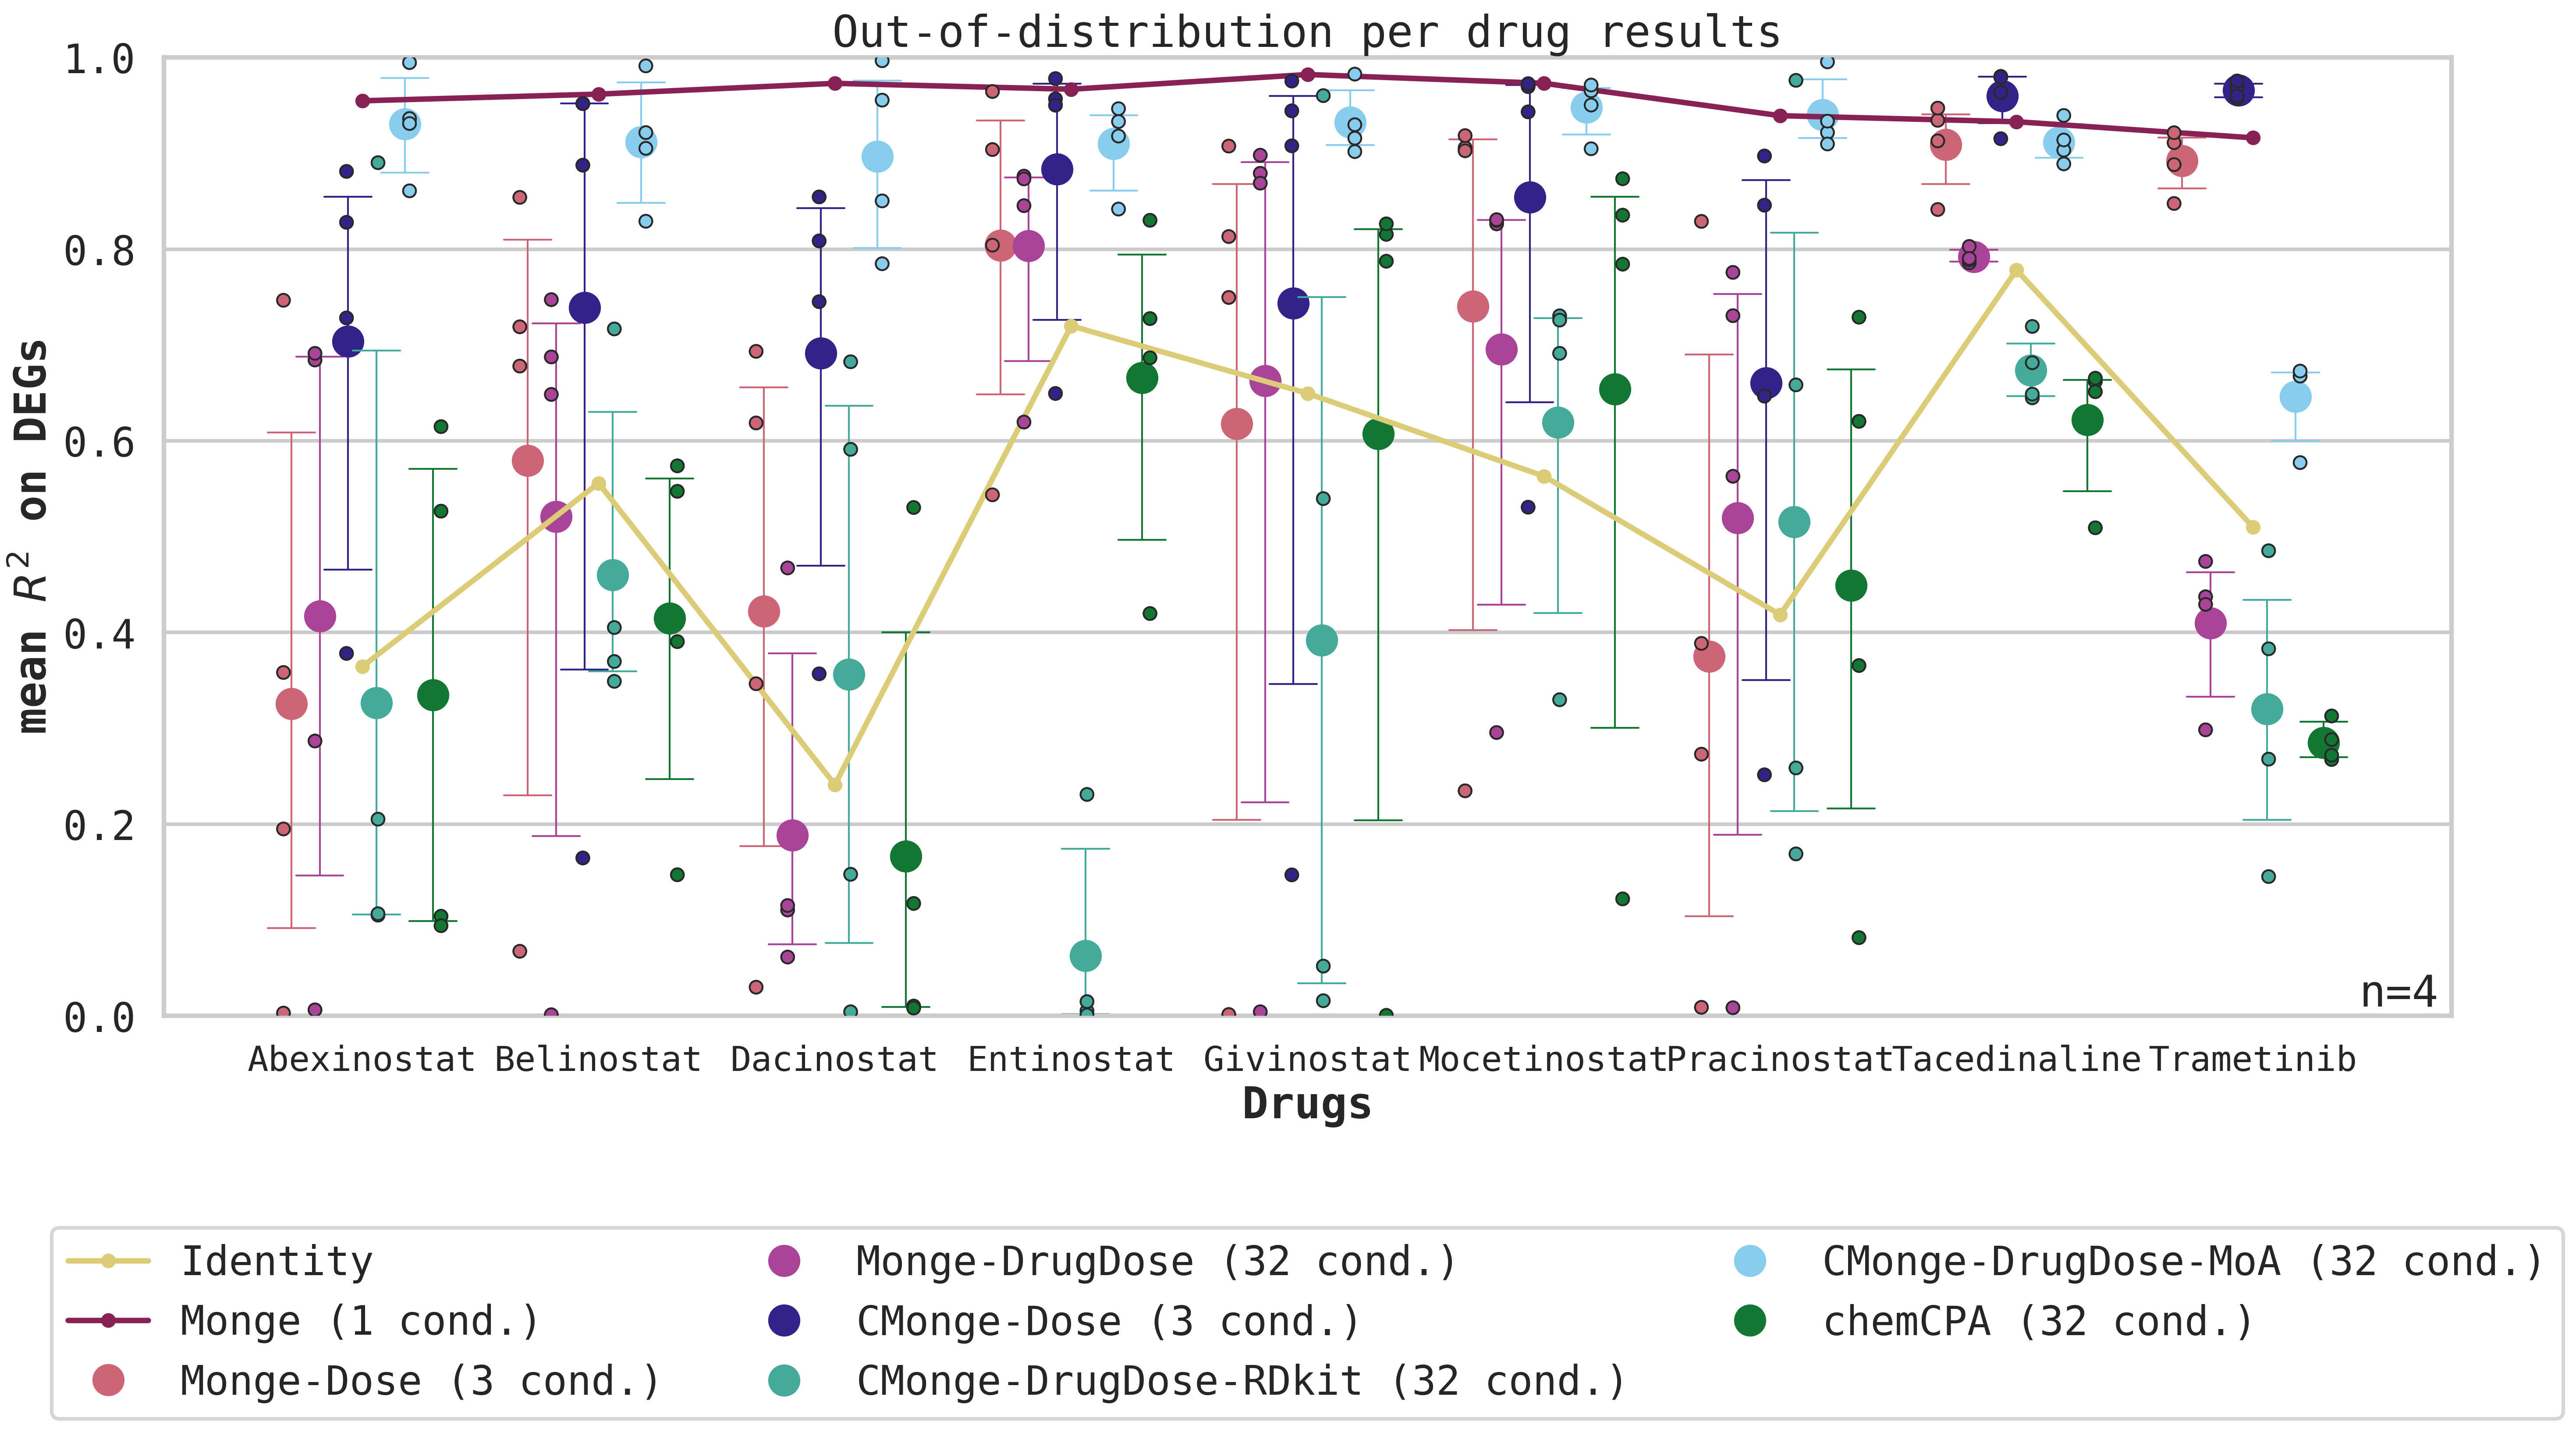

In [24]:
small_OOD_res["drug"]=small_OOD_res["drug"].apply(lambda x: x.capitalize())
f, ax = plt.subplots(1,1, figsize=(20, 9))

sns.pointplot(small_OOD_res, x="drug", y="r2", hue="model", ax=ax, dodge=0.6, markers='o', capsize=0.2,
                  palette=OOD_model_color_dict, linestyle='', err_kws={'linewidth': 1},
                 hue_order=hue_order, order=drug_order)
sns.stripplot(small_OOD_res, x="drug", y="r2", hue="model", ax=ax, dodge=0.6, 
                  palette=OOD_model_color_dict, 
                 hue_order=hue_order, order=drug_order, linewidth=1, edgecolor="gray",jitter=0, s=7, legend=False)
ax.plot(drug_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
ax.plot(drug_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")


ax.set(ylim=[0.0,1.0], ylabel="mean R2 on HVGs")
handles, labels = ax.get_legend_handles_labels()
order = [7, 6, 0, 1, 2, 3, 4, 5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=3, bbox_to_anchor=(0.5, -0.2), loc="upper center")
plt.xlabel("Drugs", weight="bold")
plt.ylabel("mean $R^2$ on DEGs", weight="bold")
plt.xticks(ax.get_xticks(), fontsize=19)
# plt.yticks(ax.get_yticks(), fontsize=14)
# plt.setp(ax.get_legend().get_title(),fontsize=14)
plt.text(x=8.45, y=0.01, s="n=4")
plt.title("Out-of-distribution per drug results")

plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/OOD_R2_pointplot.pdf", dpi=300, format='pdf', bbox_inches='tight')

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1764054531.py:7: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(small_OOD_res, x="drug", y="wasserstein", hue="model", ax=ax, dodge=0.6,
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1764054531.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(drug_monge["wasserstein"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/1764054531.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(drug_identity["wasserstein"],'r-o',c=OOD_model_color_dict["Identity"], linewi

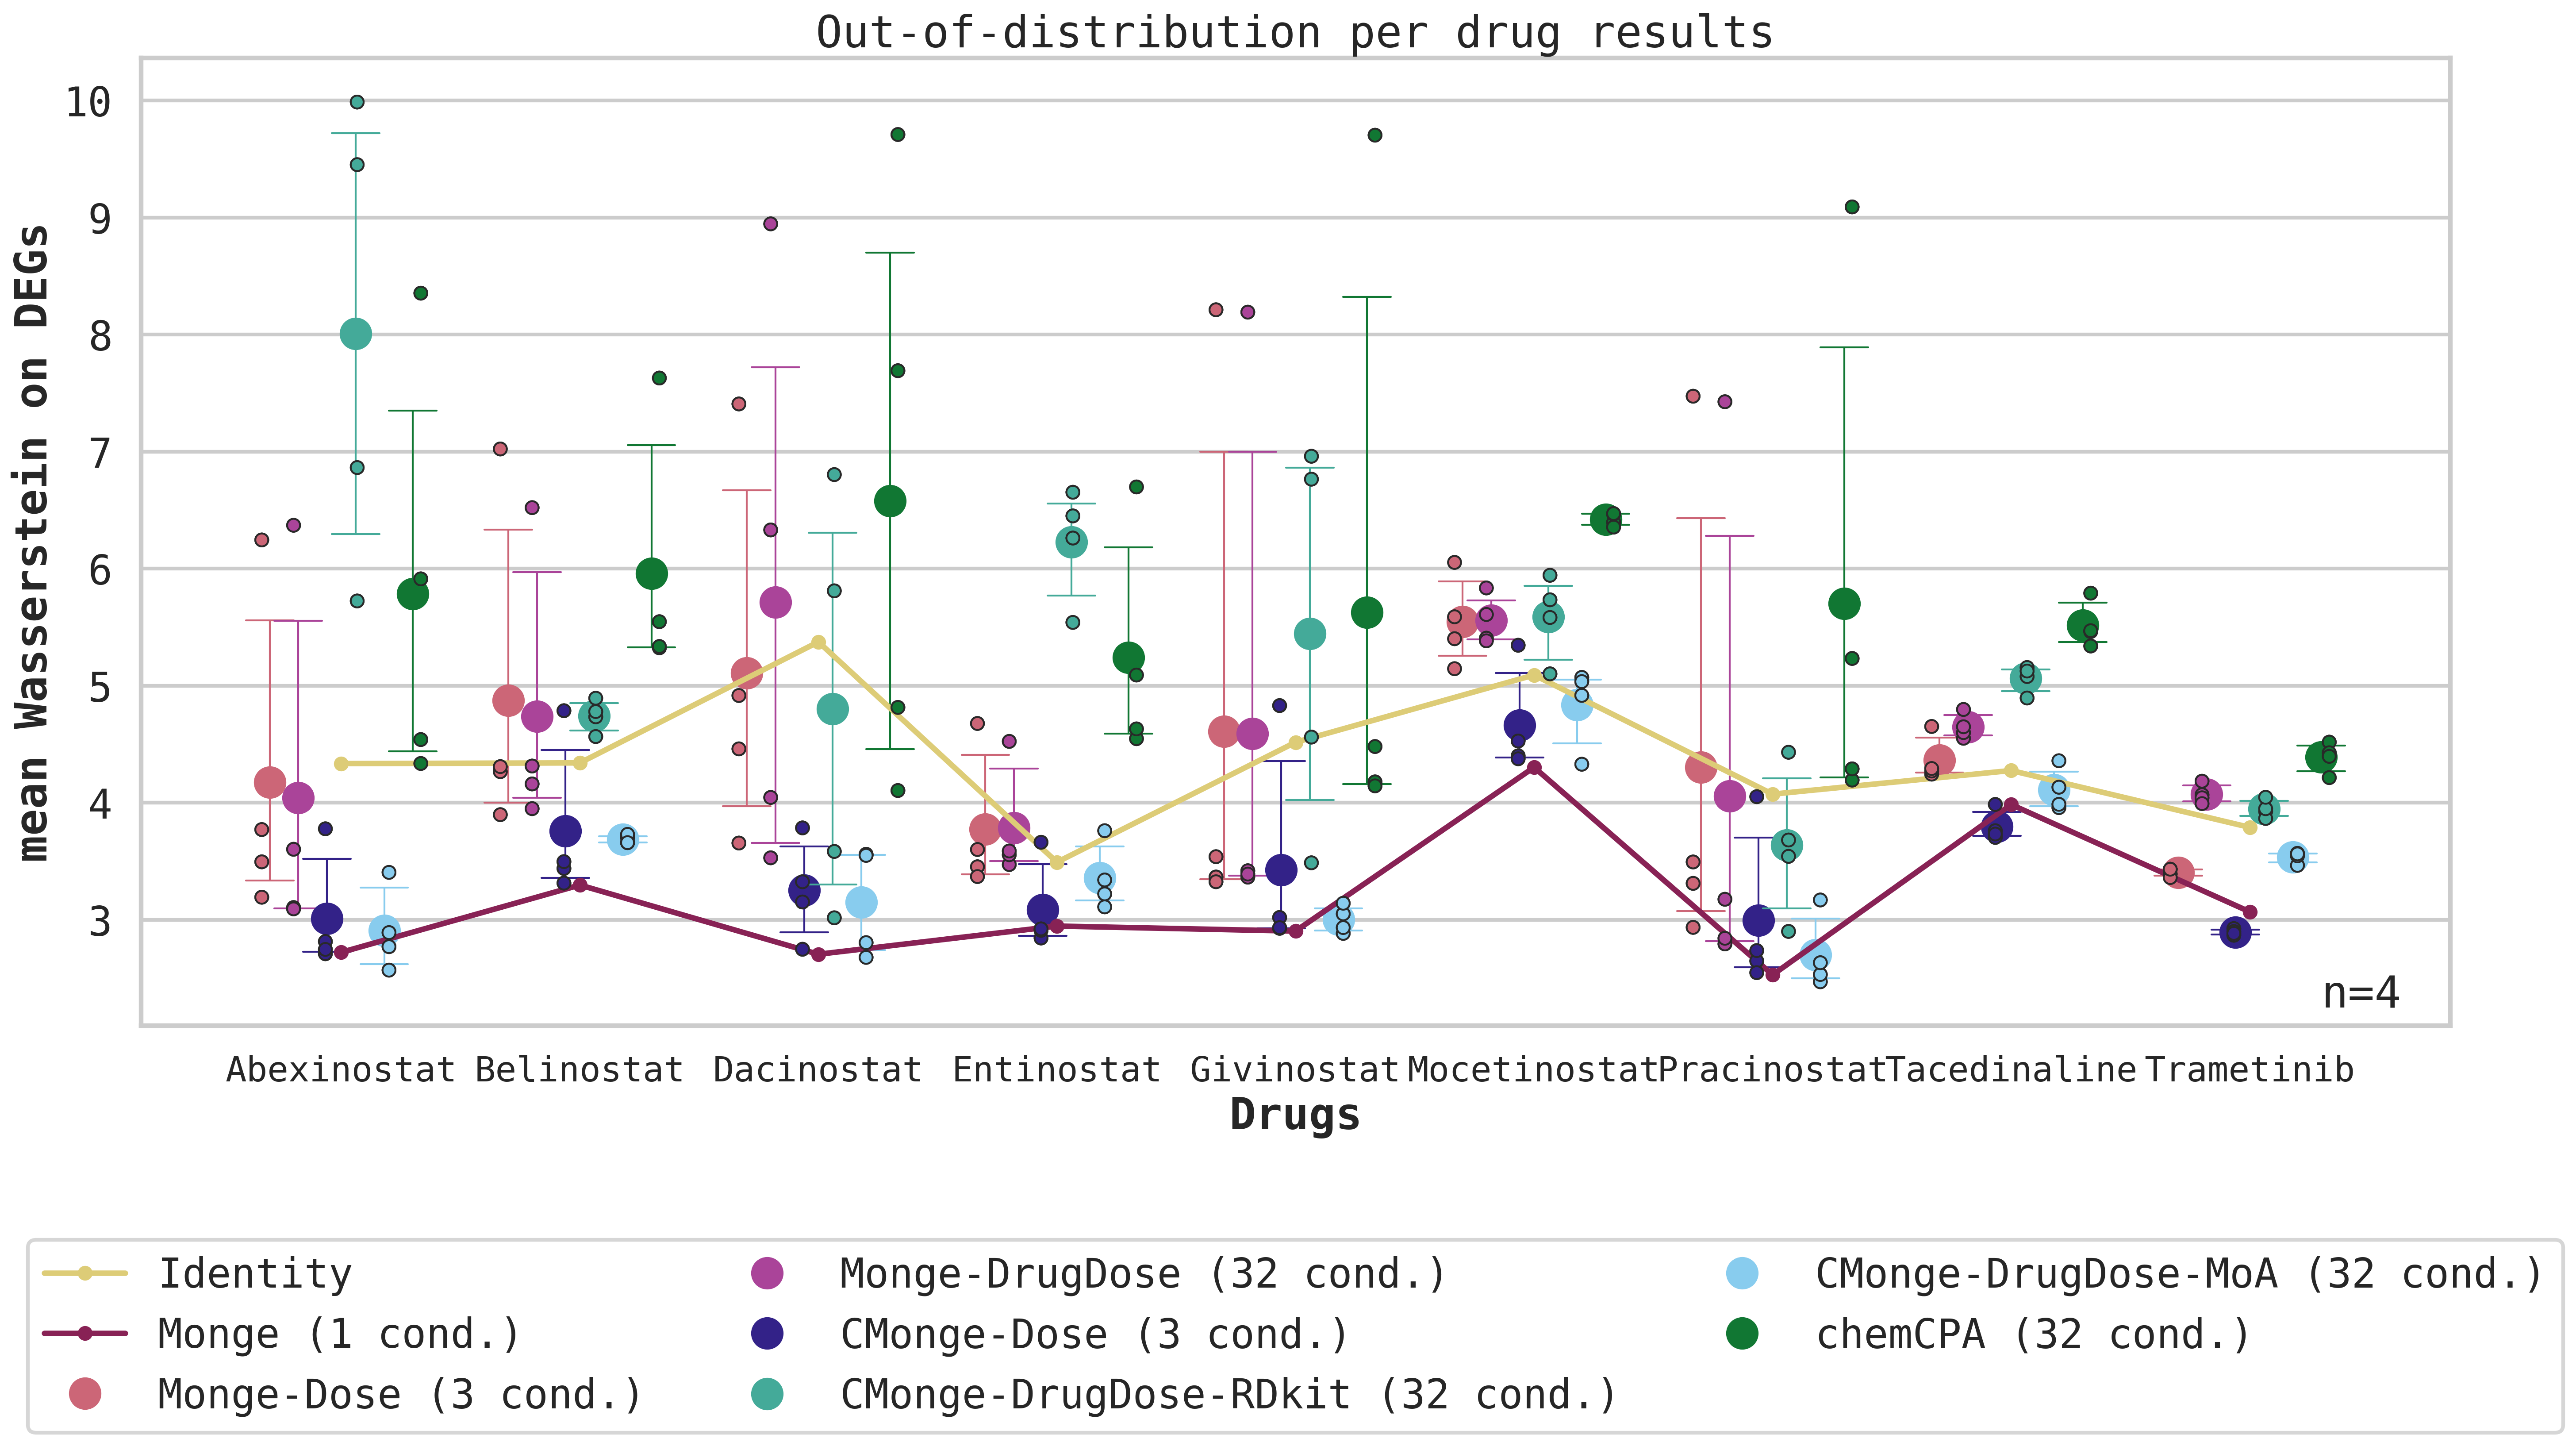

In [25]:
small_OOD_res["drug"]=small_OOD_res["drug"].apply(lambda x: x.capitalize())
f, ax = plt.subplots(1,1, figsize=(20, 9))

sns.pointplot(small_OOD_res, x="drug", y="wasserstein", hue="model", ax=ax, dodge=0.6, markers='o', capsize=0.2,
                  palette=OOD_model_color_dict, linestyle='', err_kws={'linewidth': 1},
                 hue_order=hue_order, order=drug_order)
sns.stripplot(small_OOD_res, x="drug", y="wasserstein", hue="model", ax=ax, dodge=0.6, 
                  palette=OOD_model_color_dict, linewidth=1, edgecolor="gray",jitter=0, s=7, legend=False,
                 hue_order=hue_order, order=drug_order)

ax.plot(drug_monge["wasserstein"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
ax.plot(drug_identity["wasserstein"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")

ax.set(ylabel="mean Wasserstein on HVGs")
handles, labels = ax.get_legend_handles_labels()
order = [7, 6, 0, 1, 2, 3, 4, 5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=3, bbox_to_anchor=(0.5, -0.2), loc="upper center")
plt.xlabel("Drugs", weight="bold")
plt.ylabel("mean Wasserstein on DEGs", weight="bold")
plt.xticks(ax.get_xticks(), fontsize=19)
# plt.yticks(ax.get_yticks(), fontsize=14)
# plt.setp(ax.get_legend().get_title(),fontsize=14)
plt.text(x=8.3, y=2.25, s="n=4")
plt.title("Out-of-distribution per drug results")

plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/OOD_Wasserstein_pointplot.pdf", dpi=300, format='pdf', bbox_inches='tight')

## Supplementary tables

In [26]:
small_OOD_res.groupby(["model", "dose"]).mean(numeric_only=True)


wasserstein       mmd        r2  \
model                            dose                                     
CMonge-Dose (3 cond.)            10        3.255061  0.010929  0.863884   
                                 100       3.148605  0.009003  0.931900   
                                 1000      3.197026  0.013608  0.877921   
                                 10000     4.122404  0.066403  0.526895   
CMonge-DrugDose-MoA (32 cond.)   10        3.368334       NaN  0.878839   
                                 100       3.359481       NaN  0.886875   
                                 1000      3.516342       NaN  0.894001   
                                 10000     3.658904       NaN  0.908195   
CMonge-DrugDose-RDkit (32 cond.) 10        4.852576       NaN  0.466442   
                                 100       5.539654       NaN  0.285341   
                                 1000      5.792534       NaN  0.286968   
                                 10000     4.907436       NaN  0.617797   
Identity                         10        3.444333  0.015477  0.747923   
                                 100       3.511467  0.019241  0.654652   
                                 1000      4.102985  0.037202  0.503929   
                                 10000     6.399580  0.126280  0.227371   
Monge (1 cond.)                  10        3.120116  0.009188  0.950049   
                                 100       3.162022  0.010306  0.934544   
                                 1000      3.163832  0.009611  0.960062   
                                 10000     3.199606  0.011774  0.977804   
Monge-Dose (3 cond.)             10        4.074573       NaN  0.613687   
                                 100       3.868805       NaN  0.726488   
                                 1000      3.774746       NaN  0.856421   
                                 10000     6.130077       NaN  0.321623   
Monge-DrugDose (32 cond.)        10        3.880775       NaN  0.715236   
                                 100       6.260023       NaN  0.237694   
                                 1000      4.230843       NaN  0.610503   
                                 10000     3.939706       NaN  0.663256   
chemCPA (32 cond.)               10        4.769987       NaN  0.655191   
                                 100       4.888180       NaN  0.571187   
                                 1000      5.586934       NaN  0.429289   
                                 10000     7.517485       NaN  0.210865   

                                        drug signature  sinkhorn div  \
model                            dose                                  
CMonge-Dose (3 cond.)            10           0.681313      2.646319   
                                 100          0.536846      2.540534   
                                 1000         0.790642      2.590759   
                                 10000        2.272332      3.531293   
CMonge-DrugDose-MoA (32 cond.)   10                NaN           NaN   
                                 100               NaN           NaN   
                                 1000              NaN           NaN   
                                 10000             NaN           NaN   
CMonge-DrugDose-RDkit (32 cond.) 10                NaN           NaN   
                                 100               NaN           NaN   
                                 1000              NaN           NaN   
                                 10000             NaN           NaN   
Identity                         10           1.241682      2.877735   
                                 100          1.328271      2.947068   
                                 1000         2.019697      3.542781   
                                 10000        4.757465      5.849877   
Monge (1 cond.)                  10           0.464517      2.553289   
                                 100          0.516355      2.597246   
                                 1000         0.4

In [27]:
small_OOD_res.groupby(["model", "dose"]).std(numeric_only=True)


wasserstein       mmd        r2  \
model                            dose                                     
CMonge-Dose (3 cond.)            10        0.592607  0.008660  0.197306   
                                 100       0.599898  0.005151  0.058128   
                                 1000      0.543146  0.010632  0.118080   
                                 10000     0.745126  0.042850  0.311115   
CMonge-DrugDose-MoA (32 cond.)   10        0.813403       NaN  0.086488   
                                 100       0.819118       NaN  0.097447   
                                 1000      0.675727       NaN  0.090952   
                                 10000     0.439184       NaN  0.136770   
CMonge-DrugDose-RDkit (32 cond.) 10        1.443300       NaN  0.260600   
                                 100       2.046133       NaN  0.265066   
                                 1000      1.666821       NaN  0.263325   
                                 10000     1.058631       NaN  0.315535   
Identity                         10        0.810524  0.006498  0.126773   
                                 100       0.683066  0.013750  0.260844   
                                 1000      1.000085  0.035854  0.332334   
                                 10000     1.720494  0.081285  0.212036   
Monge (1 cond.)                  10        0.692866  0.002382  0.019993   
                                 100       0.709158  0.002975  0.041586   
                                 1000      0.603449  0.001996  0.024964   
                                 10000     0.465068  0.001812  0.028761   
Monge-Dose (3 cond.)             10        0.761364       NaN  0.349241   
                                 100       0.681003       NaN  0.218906   
                                 1000      0.725690       NaN  0.111791   
                                 10000     1.587656       NaN  0.348387   
Monge-DrugDose (32 cond.)        10        0.913271       NaN  0.164656   
                                 100       1.681540       NaN  0.293681   
                                 1000      1.044799       NaN  0.287682   
                                 10000     0.850227       NaN  0.249239   
chemCPA (32 cond.)               10        0.766702       NaN  0.188269   
                                 100       0.707050       NaN  0.238990   
                                 1000      1.020832       NaN  0.307204   
                                 10000     1.885274       NaN  0.191149   

                                        drug signature  sinkhorn div  \
model                            dose                                  
CMonge-Dose (3 cond.)            10           0.378107      0.591909   
                                 100          0.195017      0.598867   
                                 1000         0.414209      0.541754   
                                 10000        1.055425      0.734839   
CMonge-DrugDose-MoA (32 cond.)   10                NaN           NaN   
                                 100               NaN           NaN   
                                 1000              NaN           NaN   
                                 10000             NaN           NaN   
CMonge-DrugDose-RDkit (32 cond.) 10                NaN           NaN   
                                 100               NaN           NaN   
                                 1000              NaN           NaN   
                                 10000             NaN           NaN   
Identity                         10           0.556890      0.810761   
                                 100          0.469662      0.682887   
                                 1000         1.224094      1.001487   
                                 10000        2.268085      1.721515   
Monge (1 cond.)                  10           0.125662      0.692423   
                                 100          0.179064      0.706681   
                                 1000         0.0

# Large OOD results

## Summary figures

In [28]:
big_chemcpa_res = big_chemcpa_res[["drug", "dose", "mean_r2", "mean_wasserstein", "mean_mmd", "model", "model_size", "n_cond", "embedding"]]
big_res = big_res[["drug", "dose", "mean_r2", "mean_wasserstein", "mean_mmd", "model", "model_size", "n_cond", "embedding"]]


In [29]:
big_results = pd.concat([big_chemcpa_res, big_res]).reset_index(drop=True)

In [30]:
big_results["dose"] = big_results["dose"].astype(str)

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/4097043898.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["chemCPA", "CMonge"])


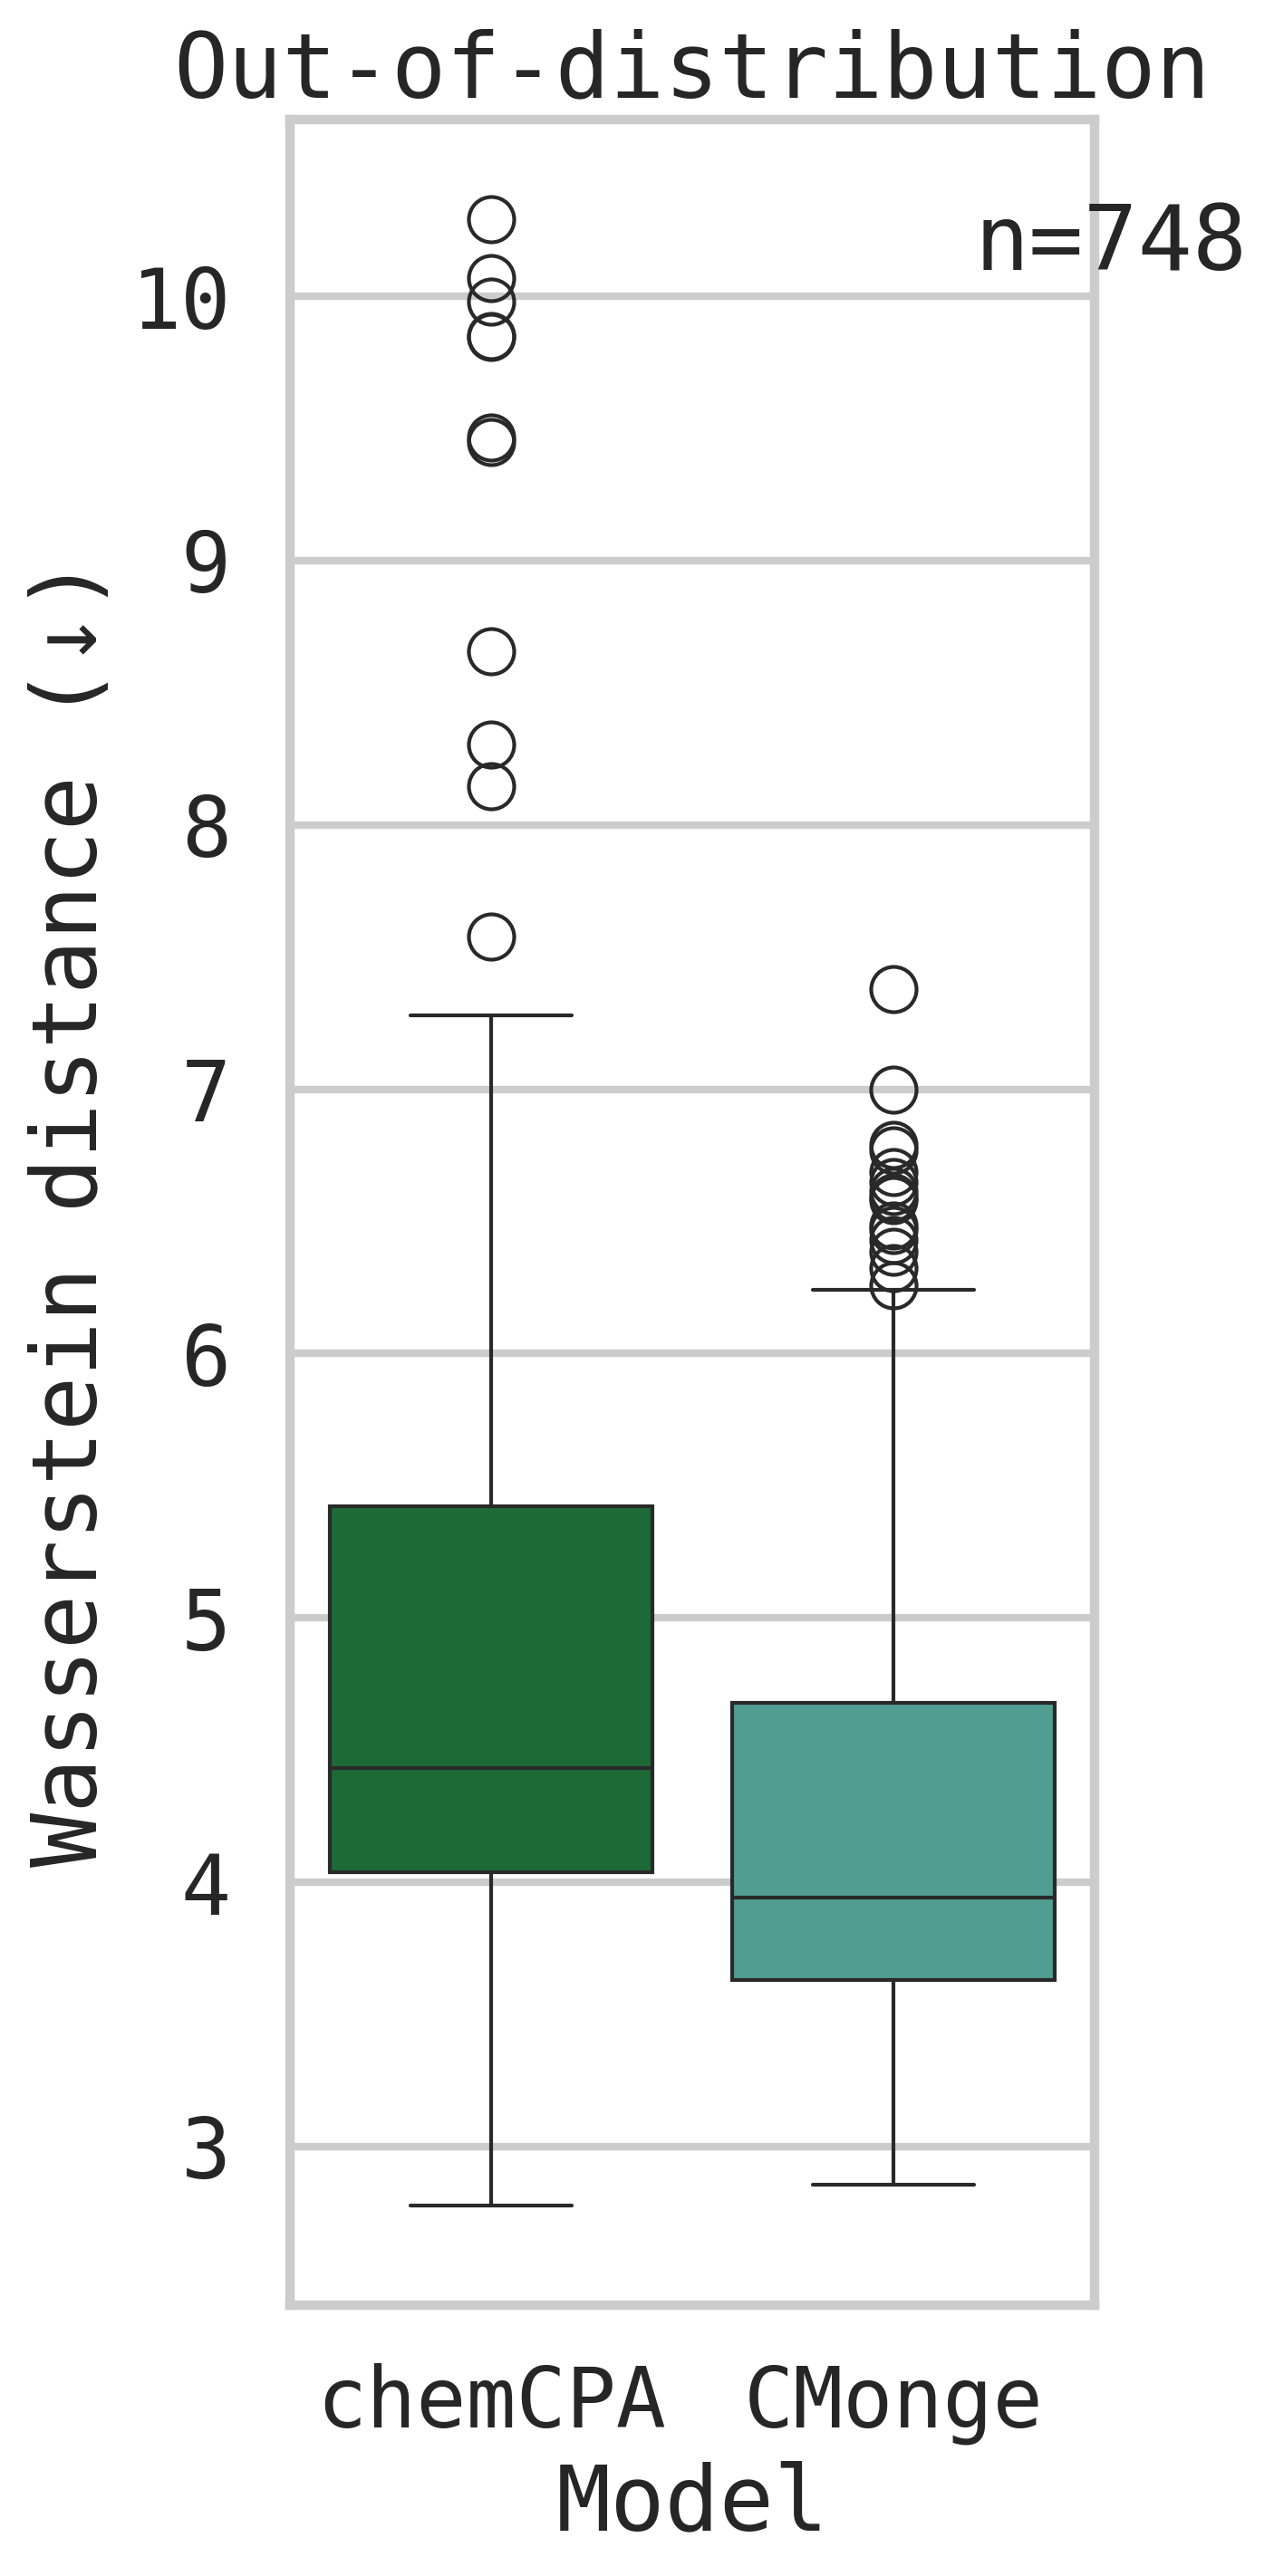

In [31]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=big_results[big_results["model"].isin(["chemCPA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)"])],
            x="model", y="mean_wasserstein",
            hue="model", palette=OOD_model_color_dict, ax=ax)
plt.xlabel("Model")
plt.ylabel("Wasserstein distance (↓)")
plt.title("Out-of-distribution")

# ax.axhline(dose_identity["r2"].iloc[-1],c=ID_model_color_dict["Identity"], linewidth=3)

ax.set_xticklabels(["chemCPA", "CMonge"])

plt.legend("", frameon=False)
plt.text(x=1.2, y=10.1 , s="n=748")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_summary_EMD_RDkit_chemCPA_NoLegend.pdf", bbox_inches="tight")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/5530366.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["chemCPA", "CMonge"])


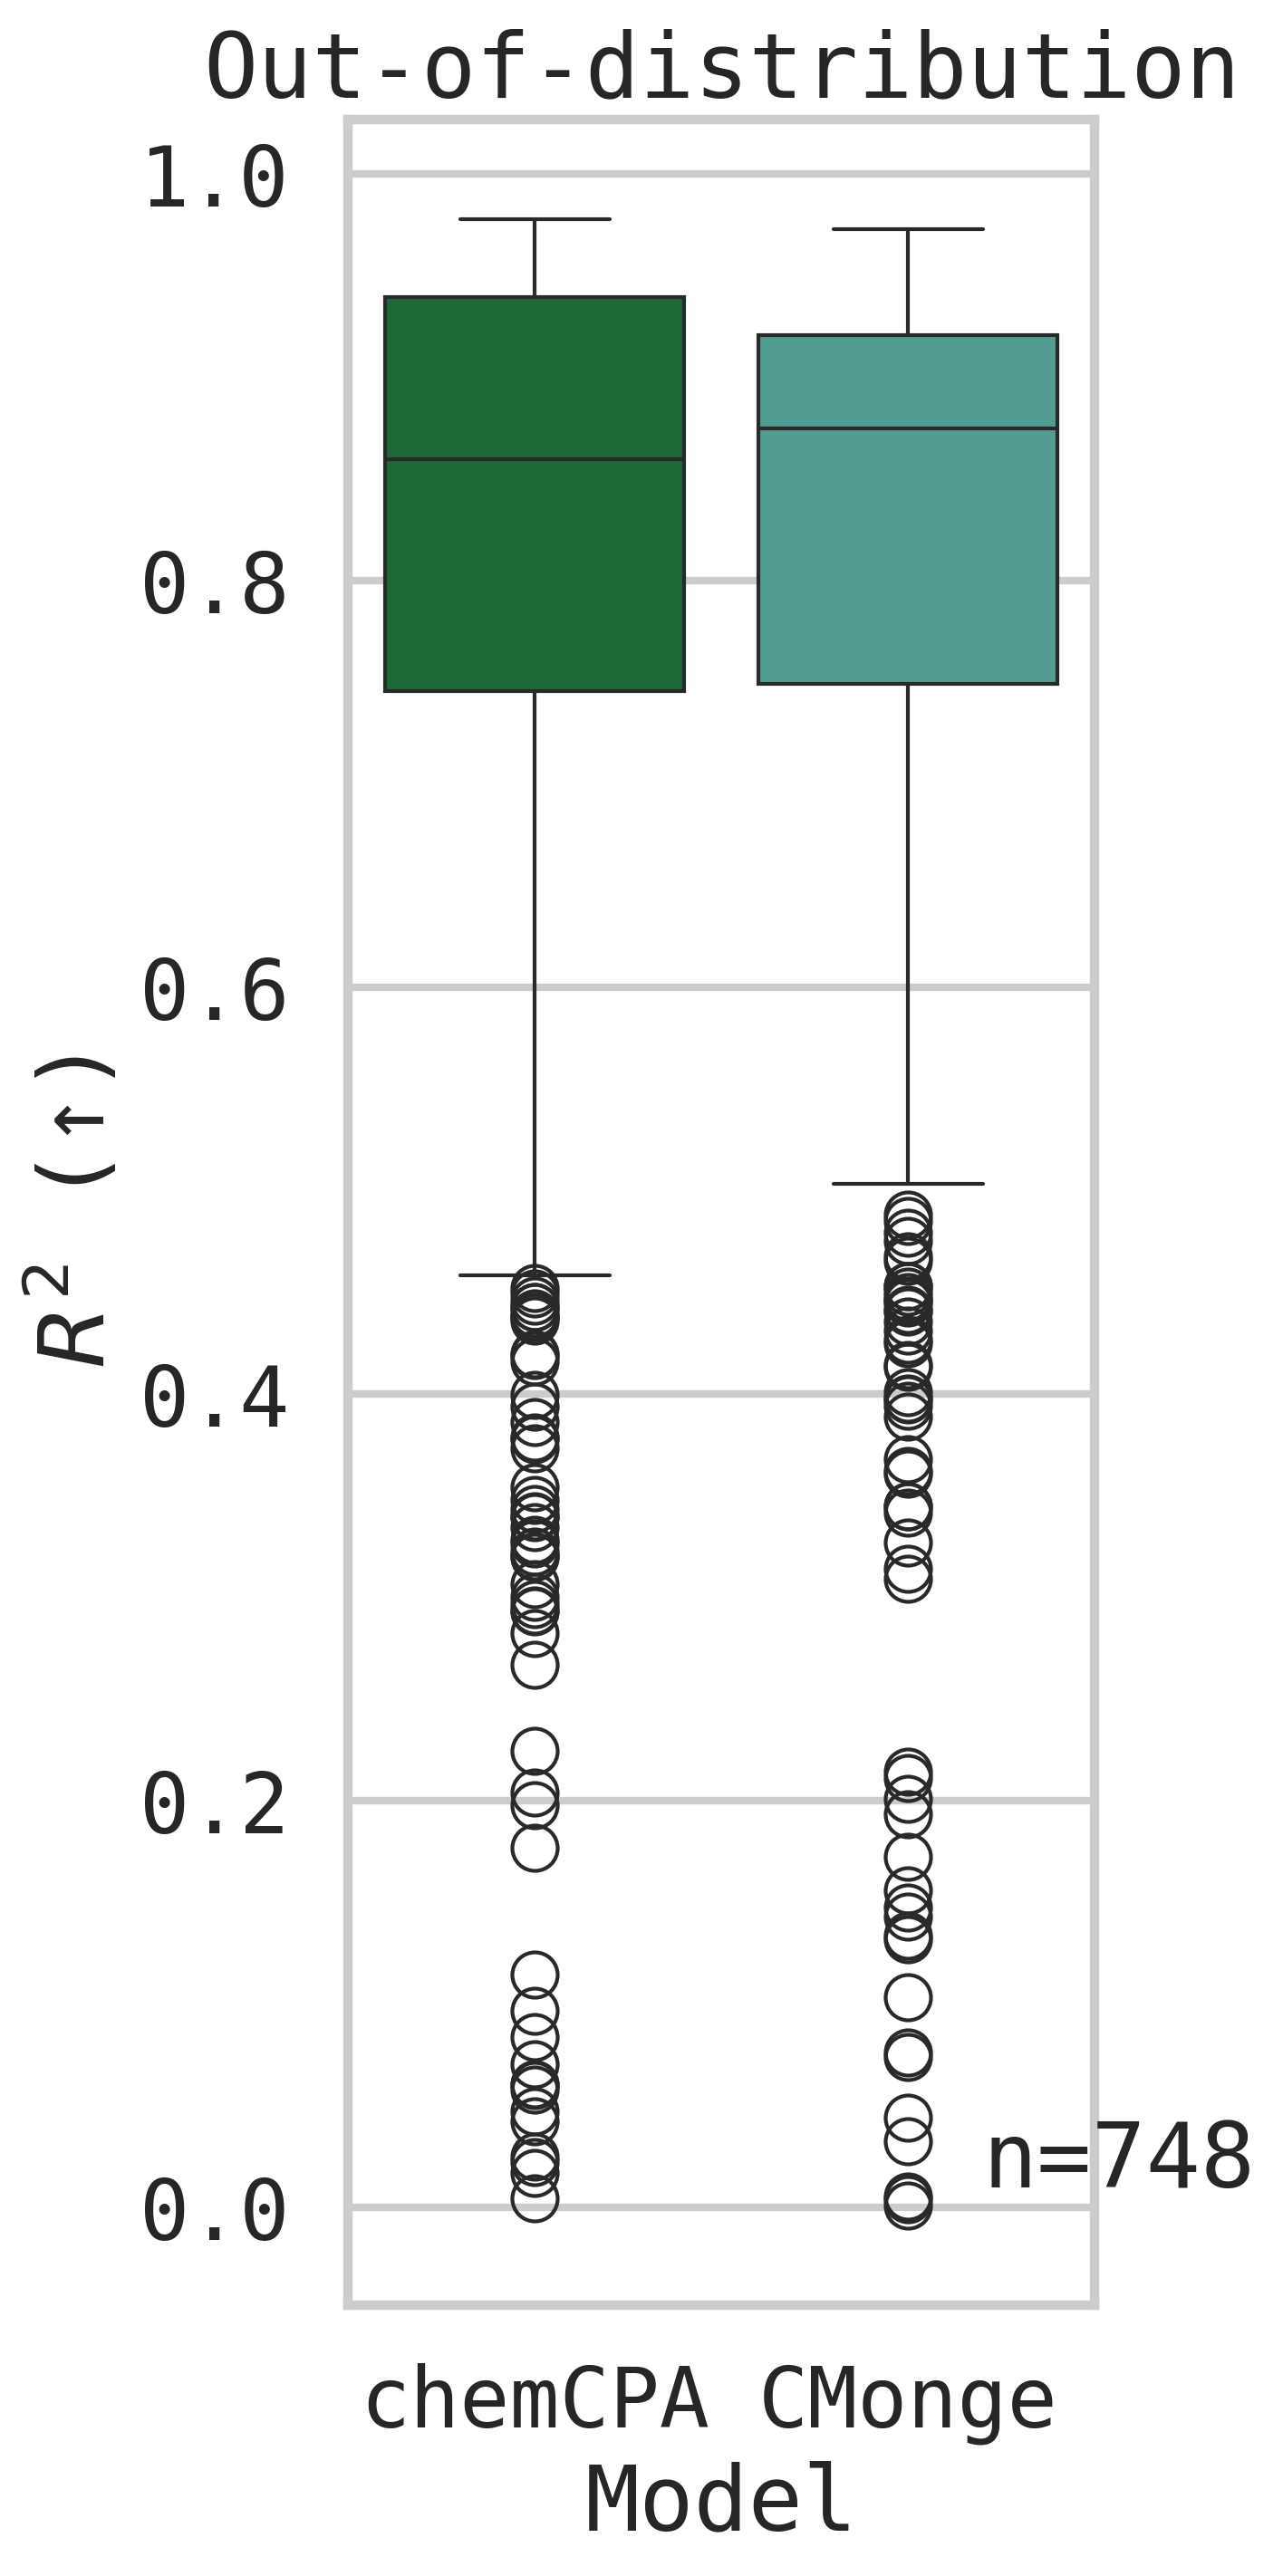

In [32]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=big_results[big_results["model"].isin(["chemCPA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)"])], x="model", y="mean_r2",
           hue="model", palette=OOD_model_color_dict, ax=ax)
plt.xlabel("Model")
plt.ylabel("$R^2$ (↑)")
plt.title("Out-of-distribution")

# ax.axhline(dose_identity["r2"].iloc[-1],c=ID_model_color_dict["Identity"], linewidth=3)

ax.set_xticklabels(["chemCPA", "CMonge"])

plt.legend("", frameon=False)
plt.text(x=1.2, y=0.01 , s="n=748")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_summary_R2_RDkit_chemCPA_NoLegend.pdf", bbox_inches="tight")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/3361440651.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["chemCPA", "CMonge"])


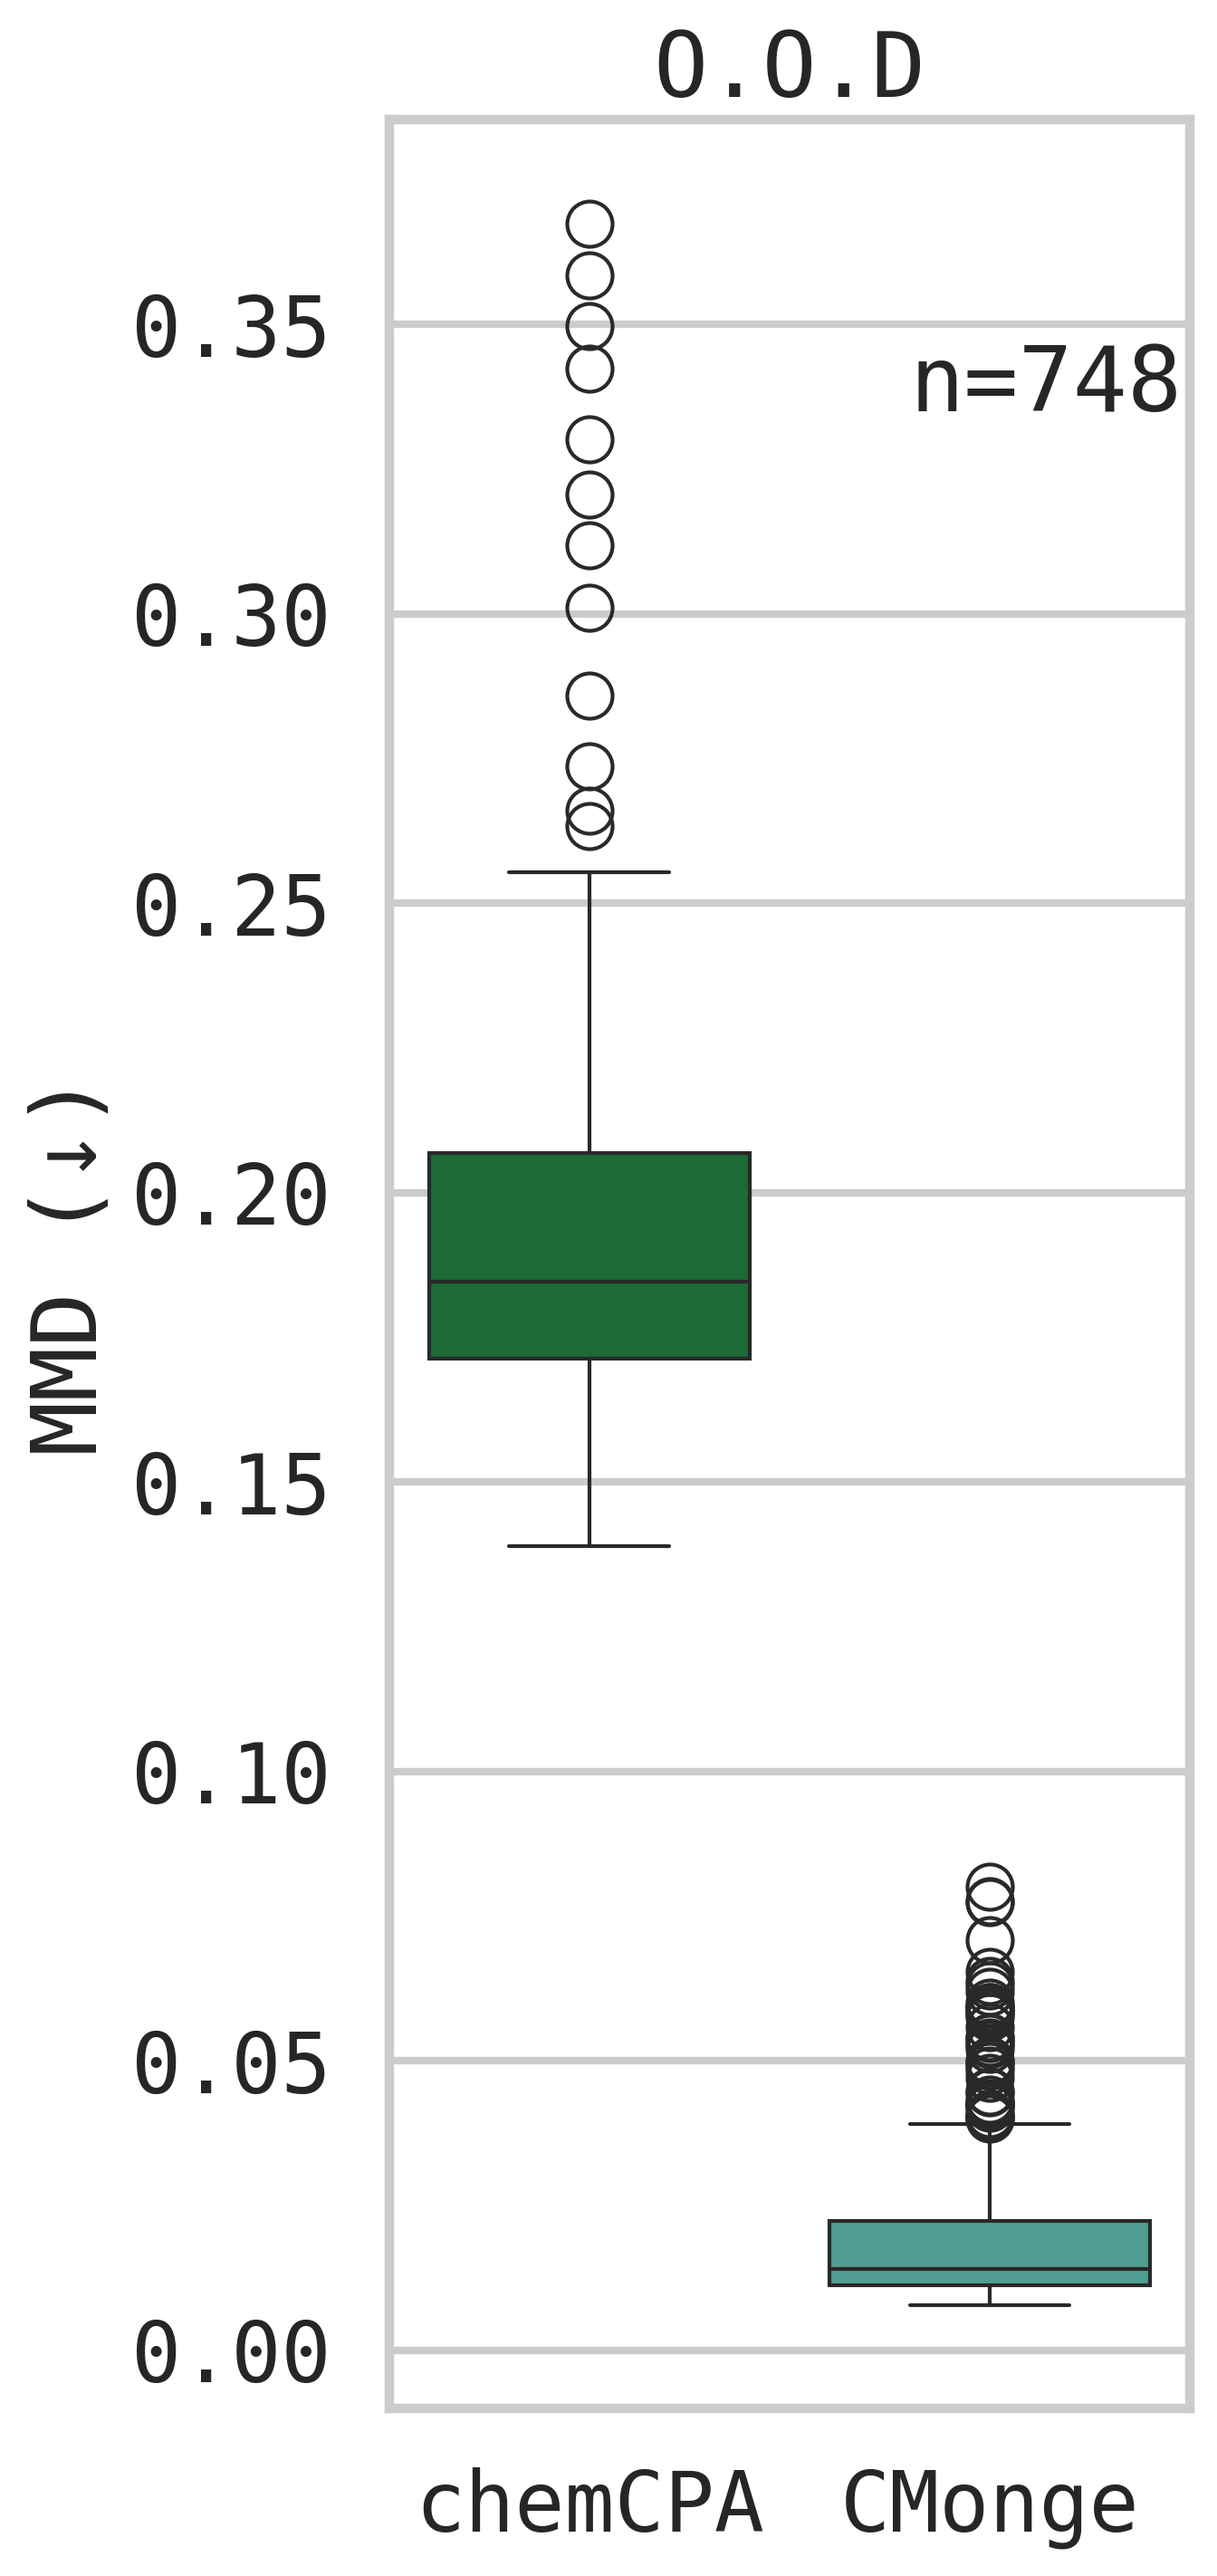

In [33]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=big_results[big_results["model"].isin(["chemCPA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)"])], x="model", y="mean_mmd",
           hue="model", palette=OOD_model_color_dict, ax=ax)
plt.xlabel("")
plt.ylabel("MMD (↓)")
plt.title("O.O.D")

# ax.axhline(dose_identity["r2"].iloc[-1],c=ID_model_color_dict["Identity"], linewidth=3)

ax.set_xticklabels(["chemCPA", "CMonge"])

plt.legend("", frameon=False)
plt.text(x=0.8, y=0.335 , s="n=748")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_summary_MMD_RDkit_chemCPA_NoLegend.pdf", bbox_inches="tight")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/481857962.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["chemCPA", "CMonge"])


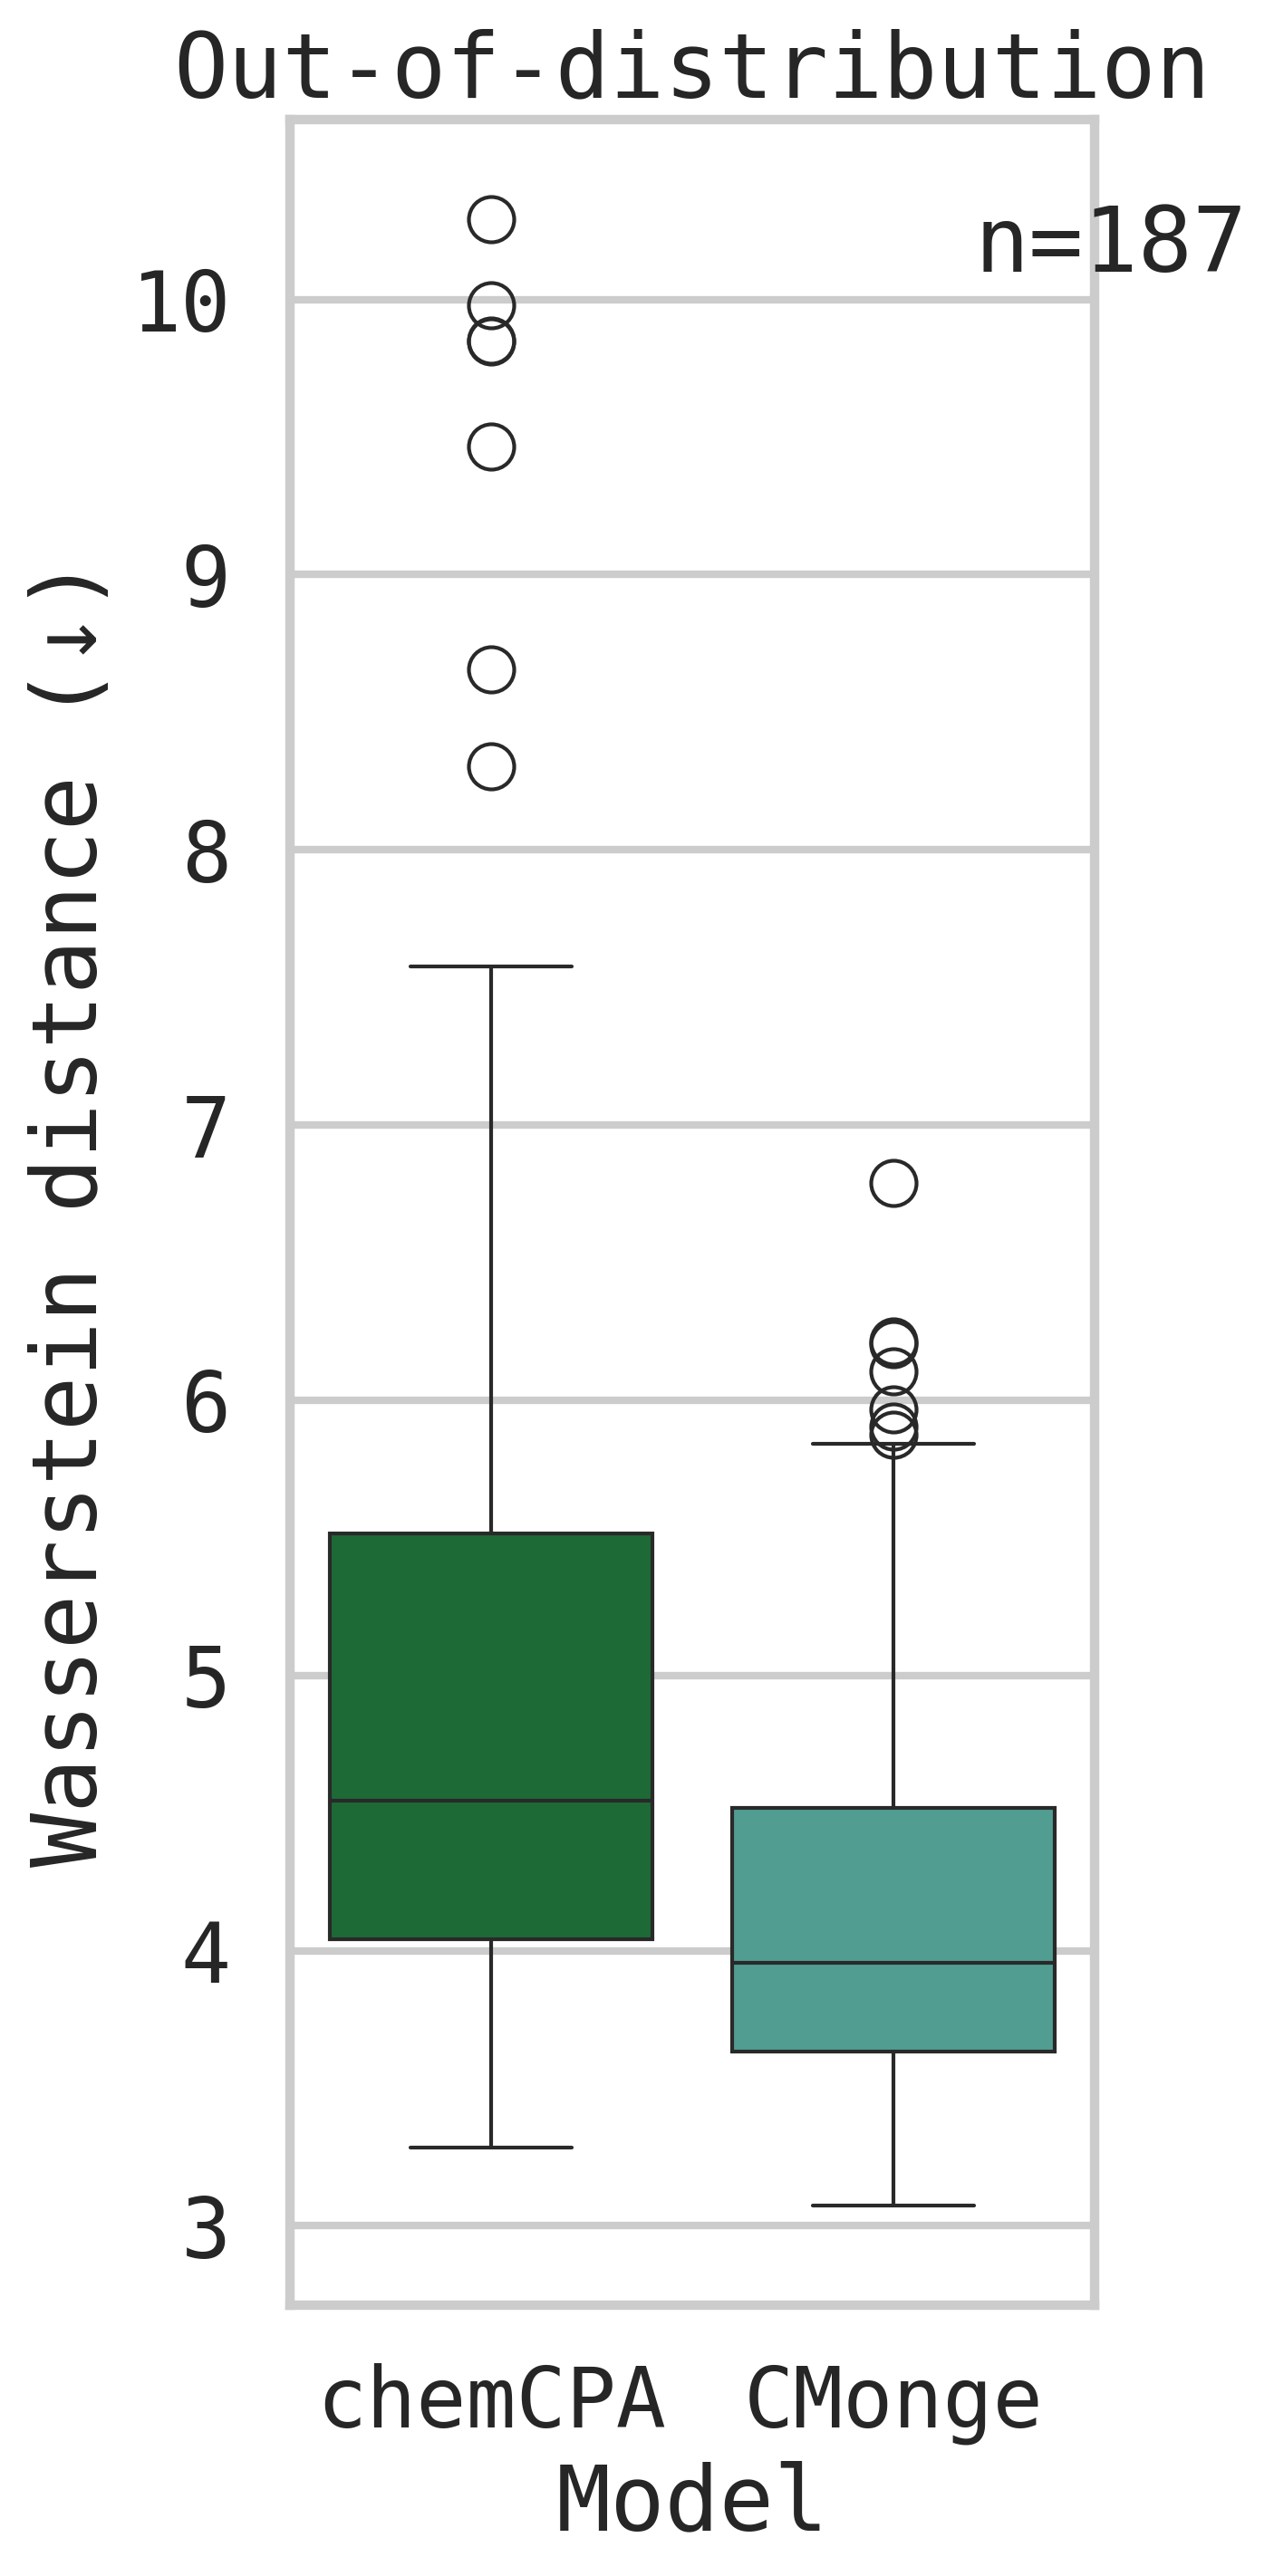

In [34]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=big_results[(big_results["model"].isin(["chemCPA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)"]))&(big_results["dose"]=="10000")],
            x="model", y="mean_wasserstein",
            hue="model", palette=OOD_model_color_dict, ax=ax)
plt.xlabel("Model")
plt.ylabel("Wasserstein distance (↓)")
plt.title("Out-of-distribution")

# ax.axhline(dose_identity["r2"].iloc[-1],c=ID_model_color_dict["Identity"], linewidth=3)

ax.set_xticklabels(["chemCPA", "CMonge"])

plt.legend("", frameon=False)
plt.text(x=1.2, y=10.1 , s="n=187")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_HighDose_EMD_RDkit_chemCPA_NoLegend.pdf", bbox_inches="tight")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/428996092.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["chemCPA", "CMonge"])


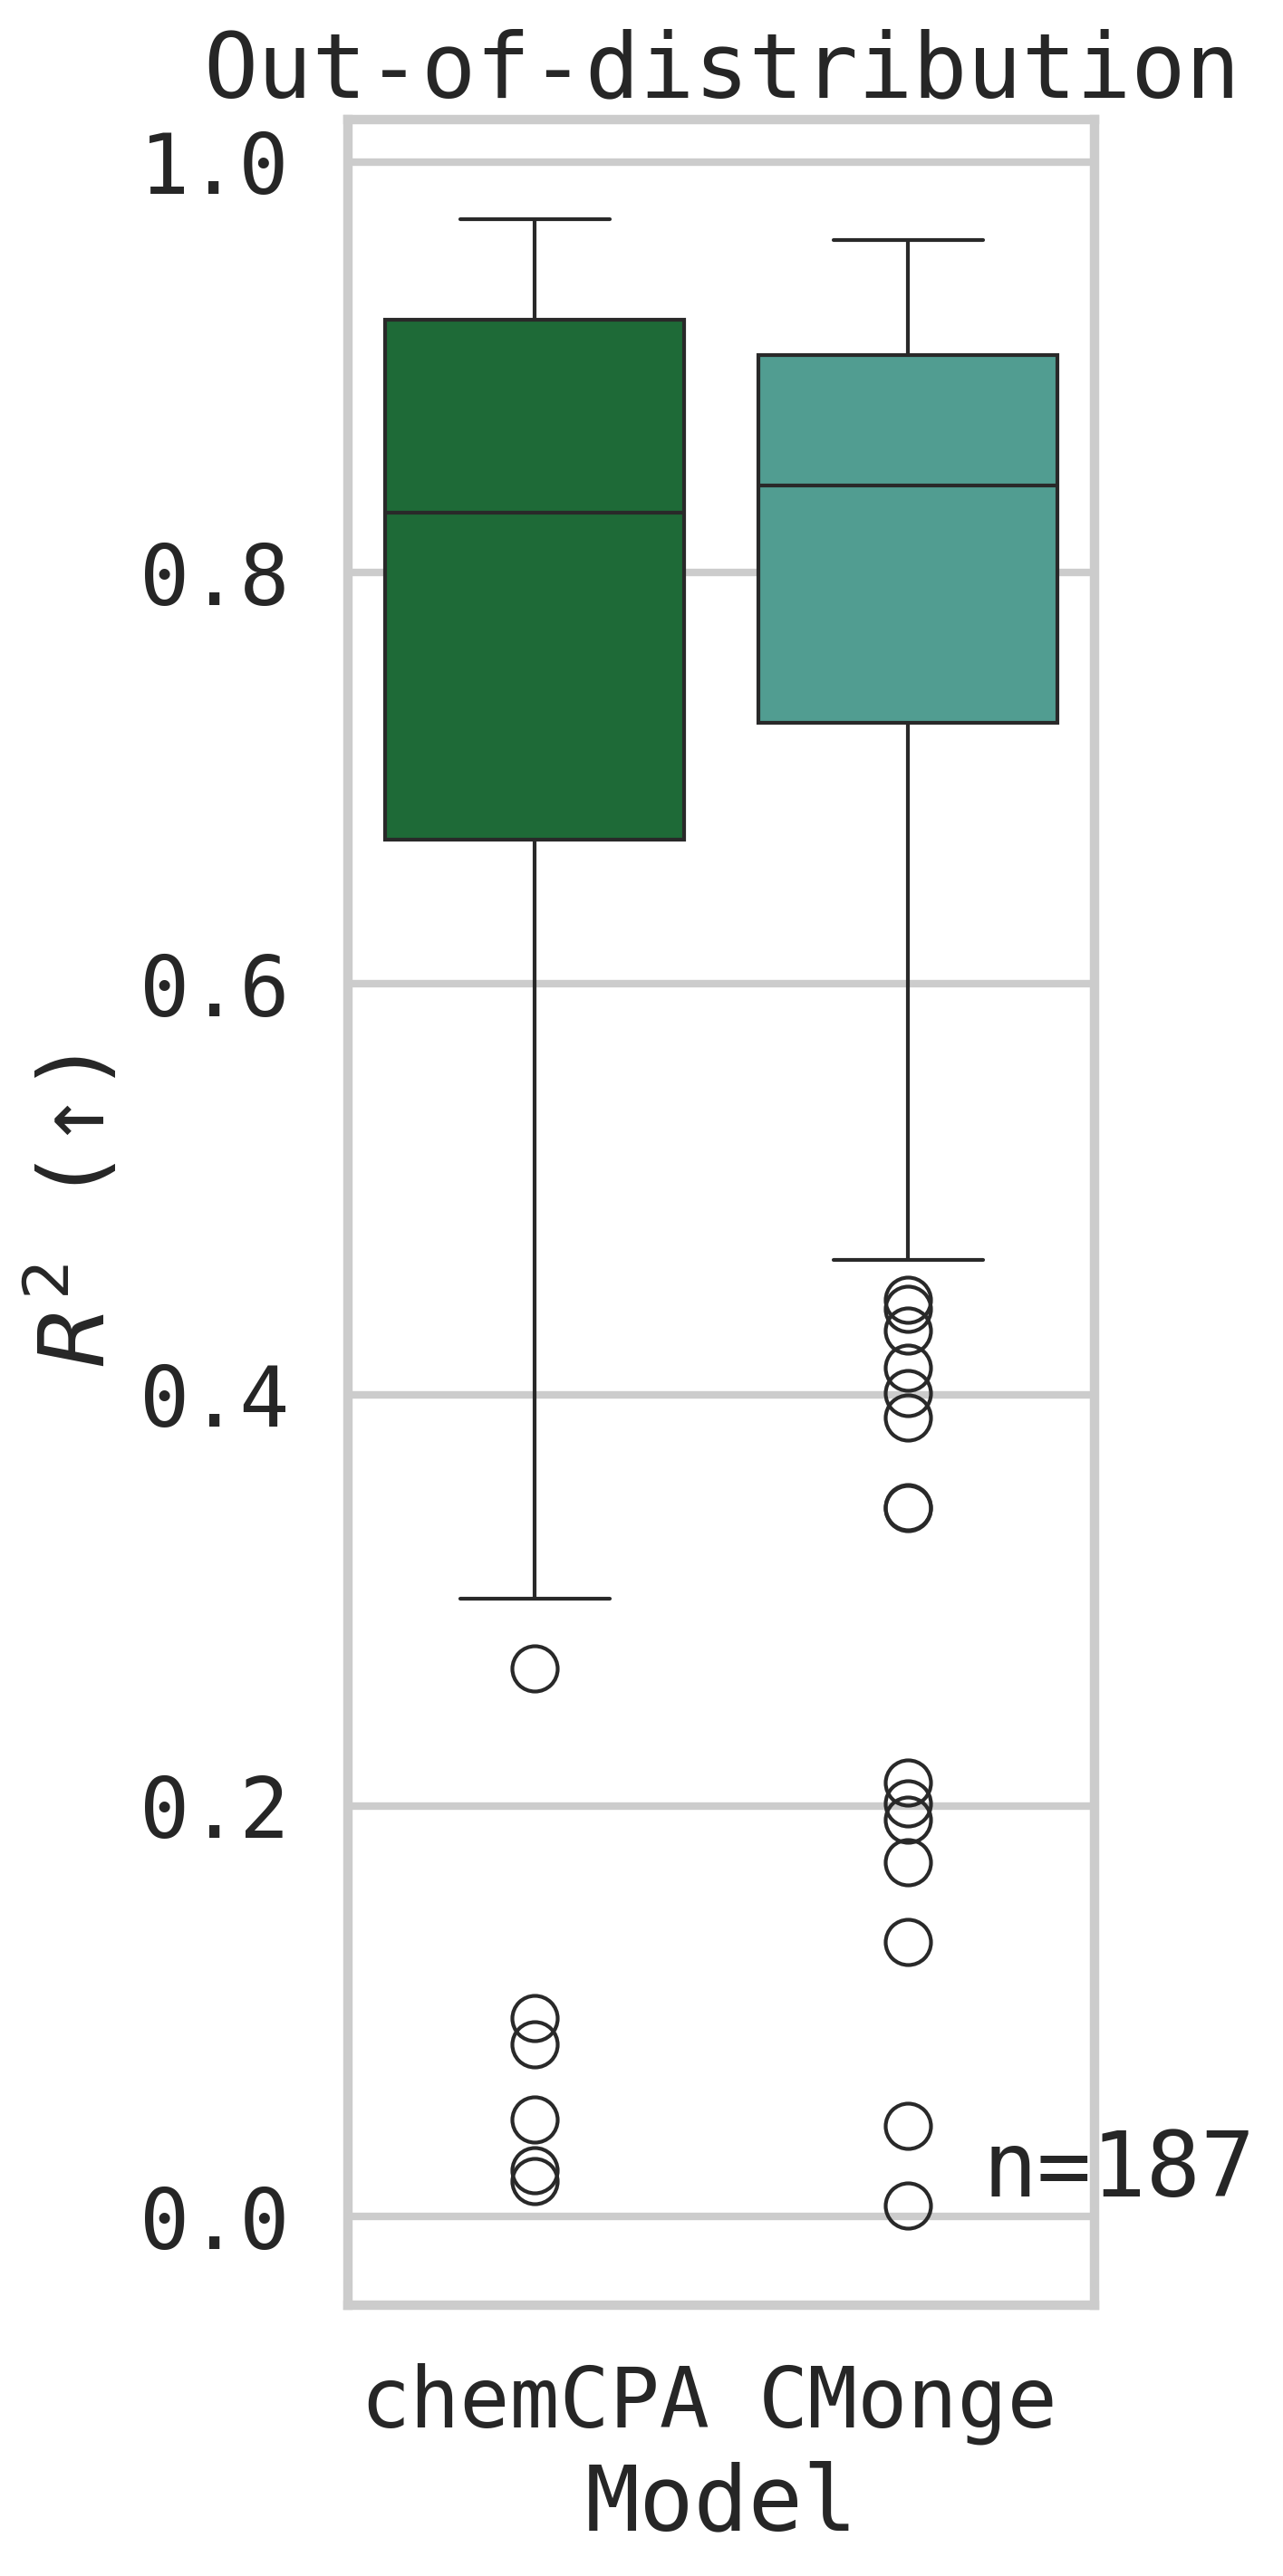

In [35]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=big_results[(big_results["model"].isin(["chemCPA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)"]))&(big_results["dose"]=="10000")],
            x="model", y="mean_r2",
           hue="model", palette=OOD_model_color_dict, ax=ax)
plt.xlabel("Model")
plt.ylabel("$R^2$ (↑)")
plt.title("Out-of-distribution")

# ax.axhline(dose_identity["r2"].iloc[-1],c=ID_model_color_dict["Identity"], linewidth=3)

ax.set_xticklabels(["chemCPA", "CMonge"])

plt.legend("", frameon=False)
plt.text(x=1.2, y=0.01 , s="n=187")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_HighDose_R2_RDkit_chemCPA_NoLegend.pdf", bbox_inches="tight")


/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_58128/602801754.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["chemCPA", "CMonge"])


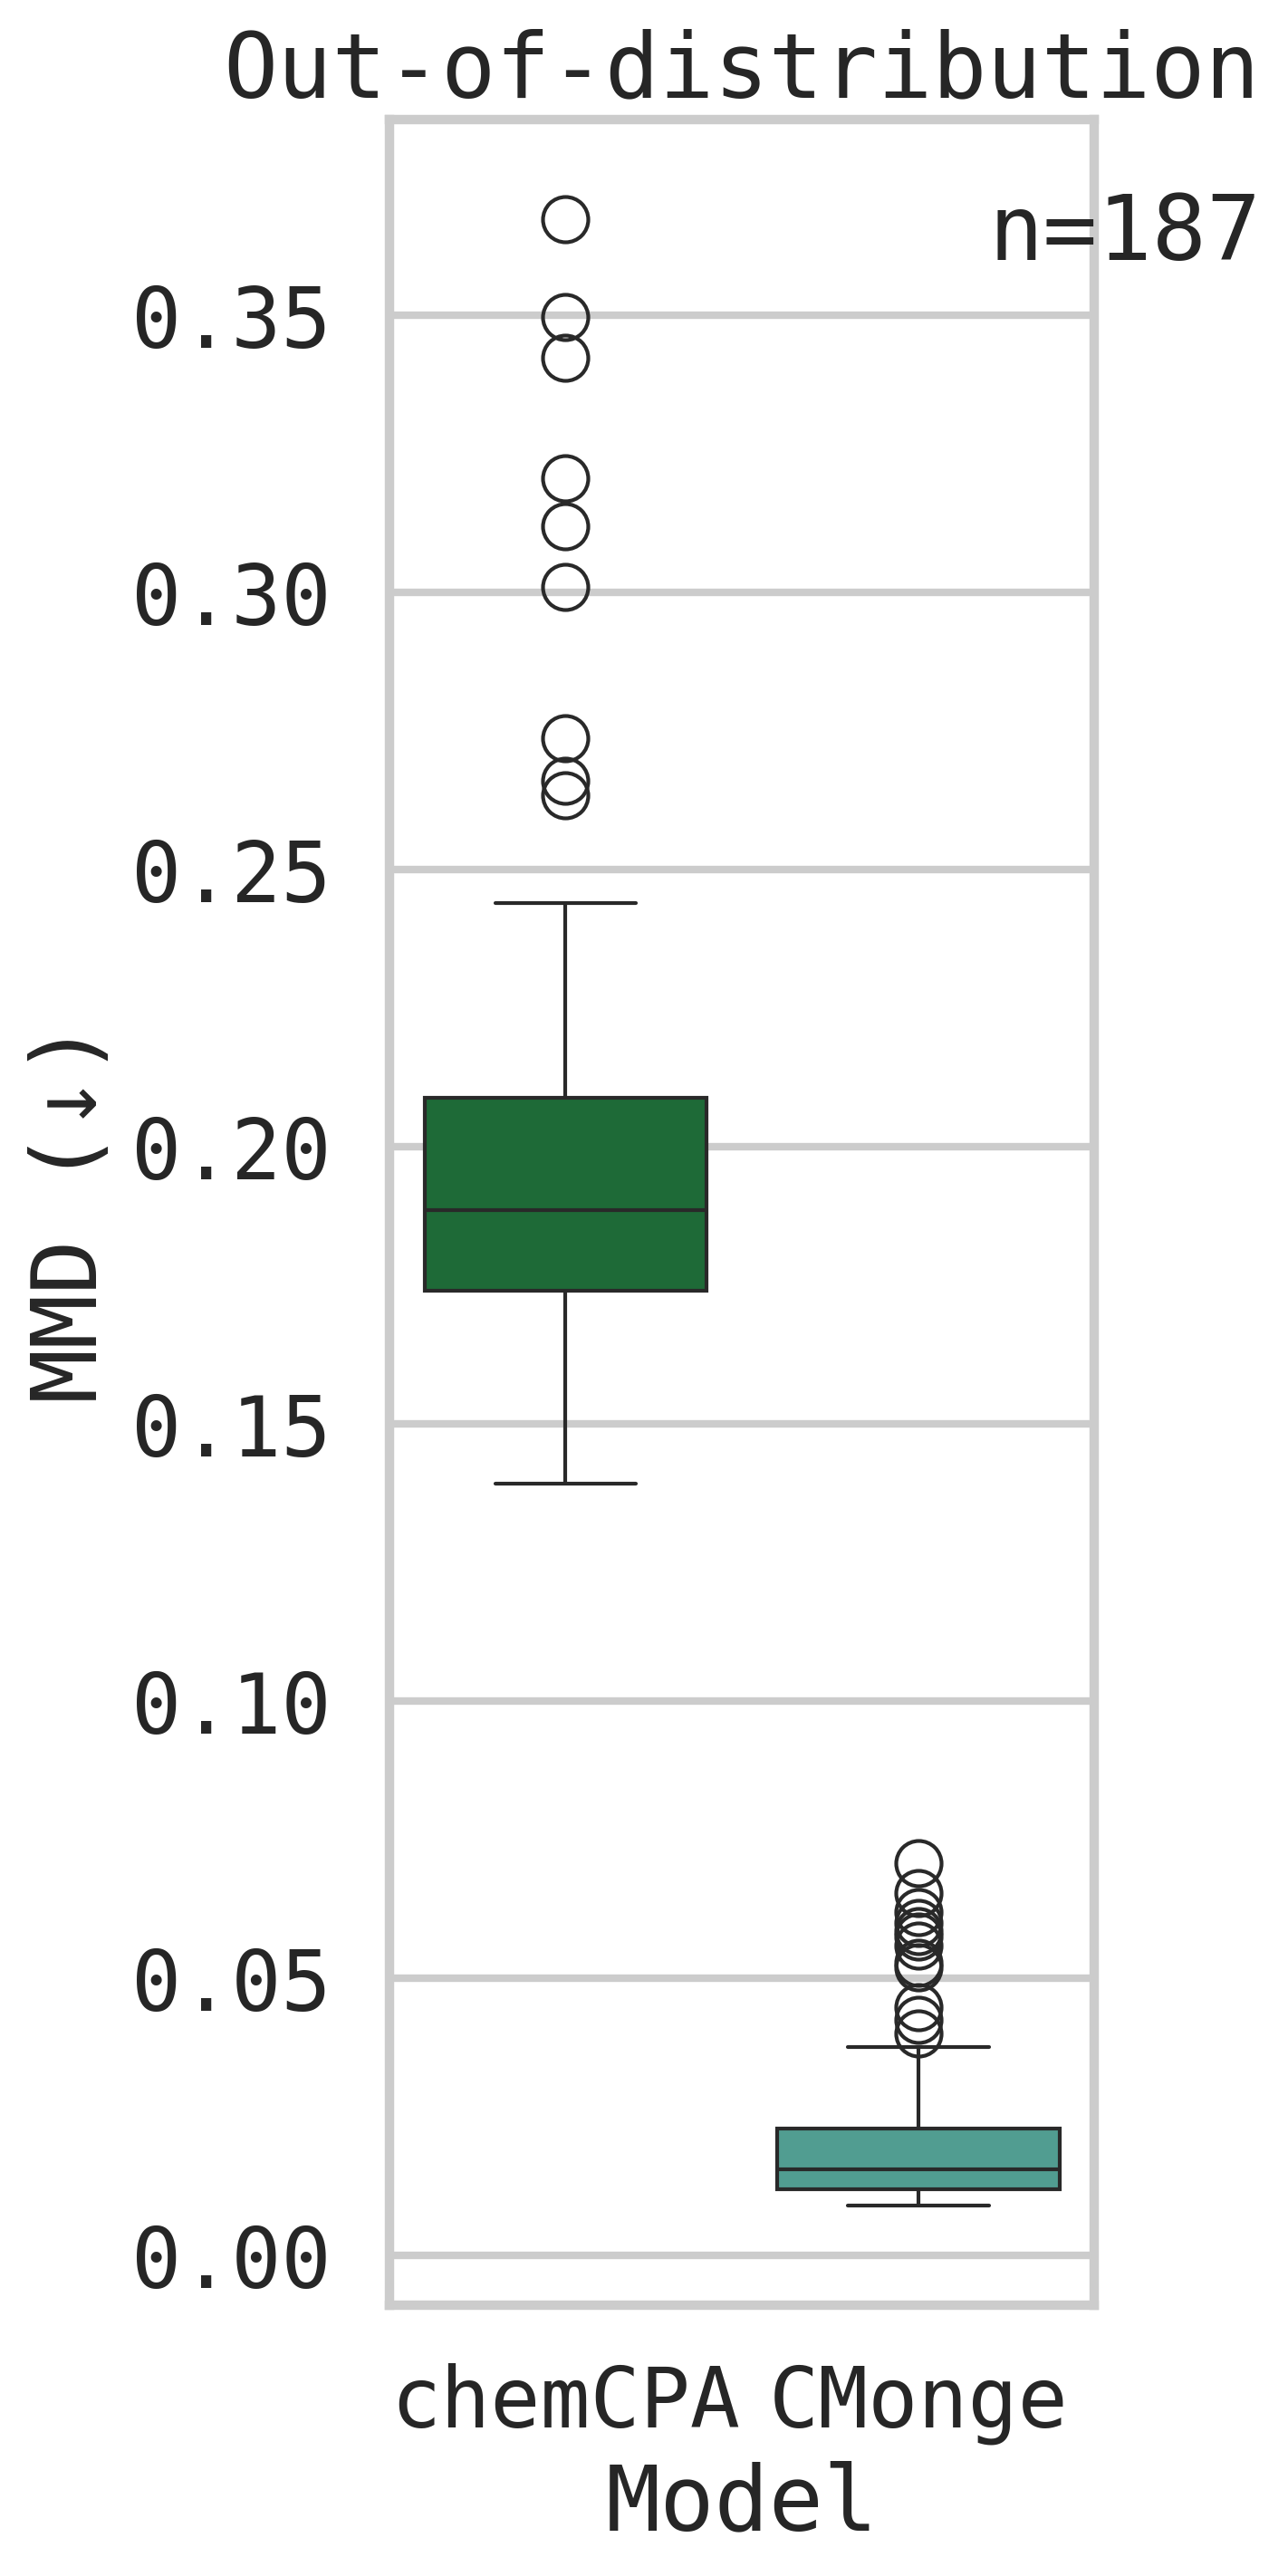

In [36]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(data=big_results[(big_results["model"].isin(["chemCPA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)"]))&(big_results["dose"]=="10000")],
            x="model", y="mean_mmd",
           hue="model", palette=OOD_model_color_dict, ax=ax)
plt.xlabel("Model")
plt.ylabel("MMD (↓)")
plt.title("Out-of-distribution")

# ax.axhline(dose_identity["r2"].iloc[-1],c=ID_model_color_dict["Identity"], linewidth=3)

ax.set_xticklabels(["chemCPA", "CMonge"])

plt.legend("", frameon=False)
plt.text(x=1.2, y=0.36 , s="n=187")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_HighDose_MMD_RDkit_chemCPA_NoLegend.pdf", bbox_inches="tight")


## Main figures

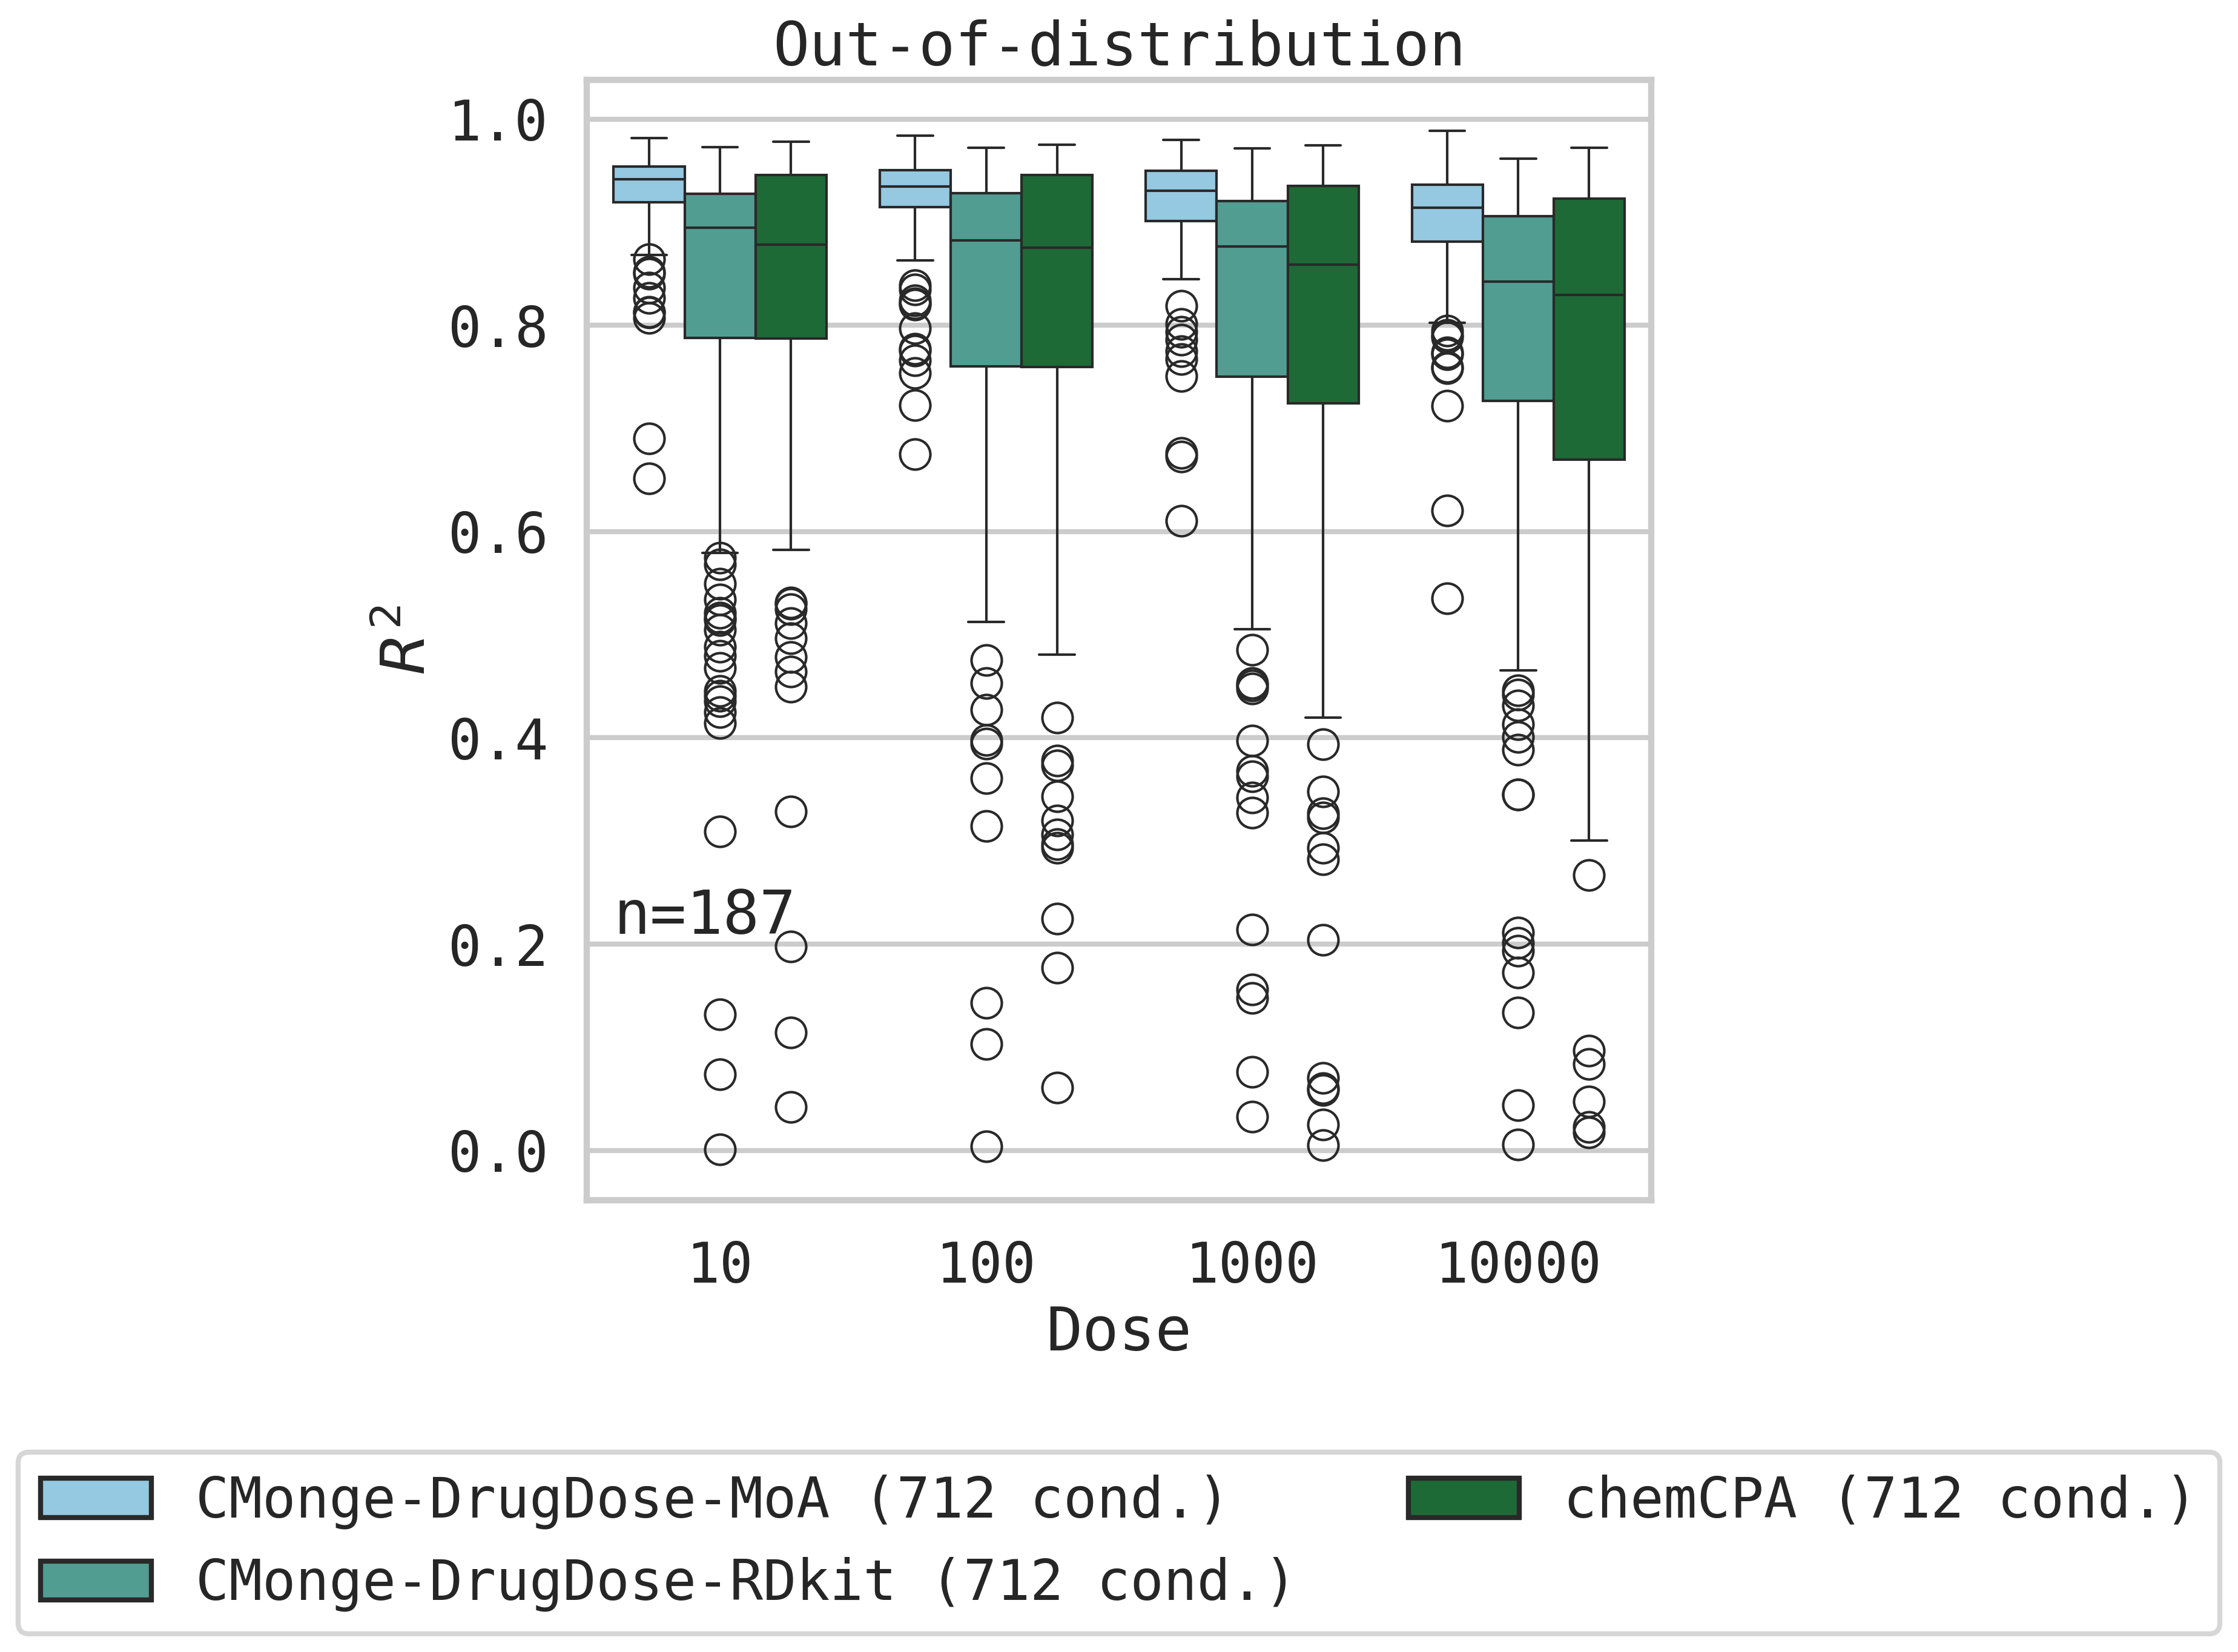

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

sns.boxplot(data=big_results, x="dose", y="mean_r2", hue="model", palette=OOD_model_color_dict,
            hue_order=["CMonge-DrugDose-MoA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)", "chemCPA (712 cond.)"], ax=ax)

# ax.plot(dose_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
# ax.plot(dose_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")

plt.title("Out-of-distribution")
plt.ylabel("$R^2$")
plt.xlabel("Dose")

# handles, labels = ax.get_legend_handles_labels()
# order = [3,2, 0, 1]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="", ncols=2, bbox_to_anchor=(0.5, -0.2), loc="upper center")
plt.legend(title="", ncols=2, bbox_to_anchor=(0.5, -0.2), loc="upper center")

plt.text(x=-0.4, y=0.21 , s="n=187")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_legend.pdf", bbox_inches="tight")

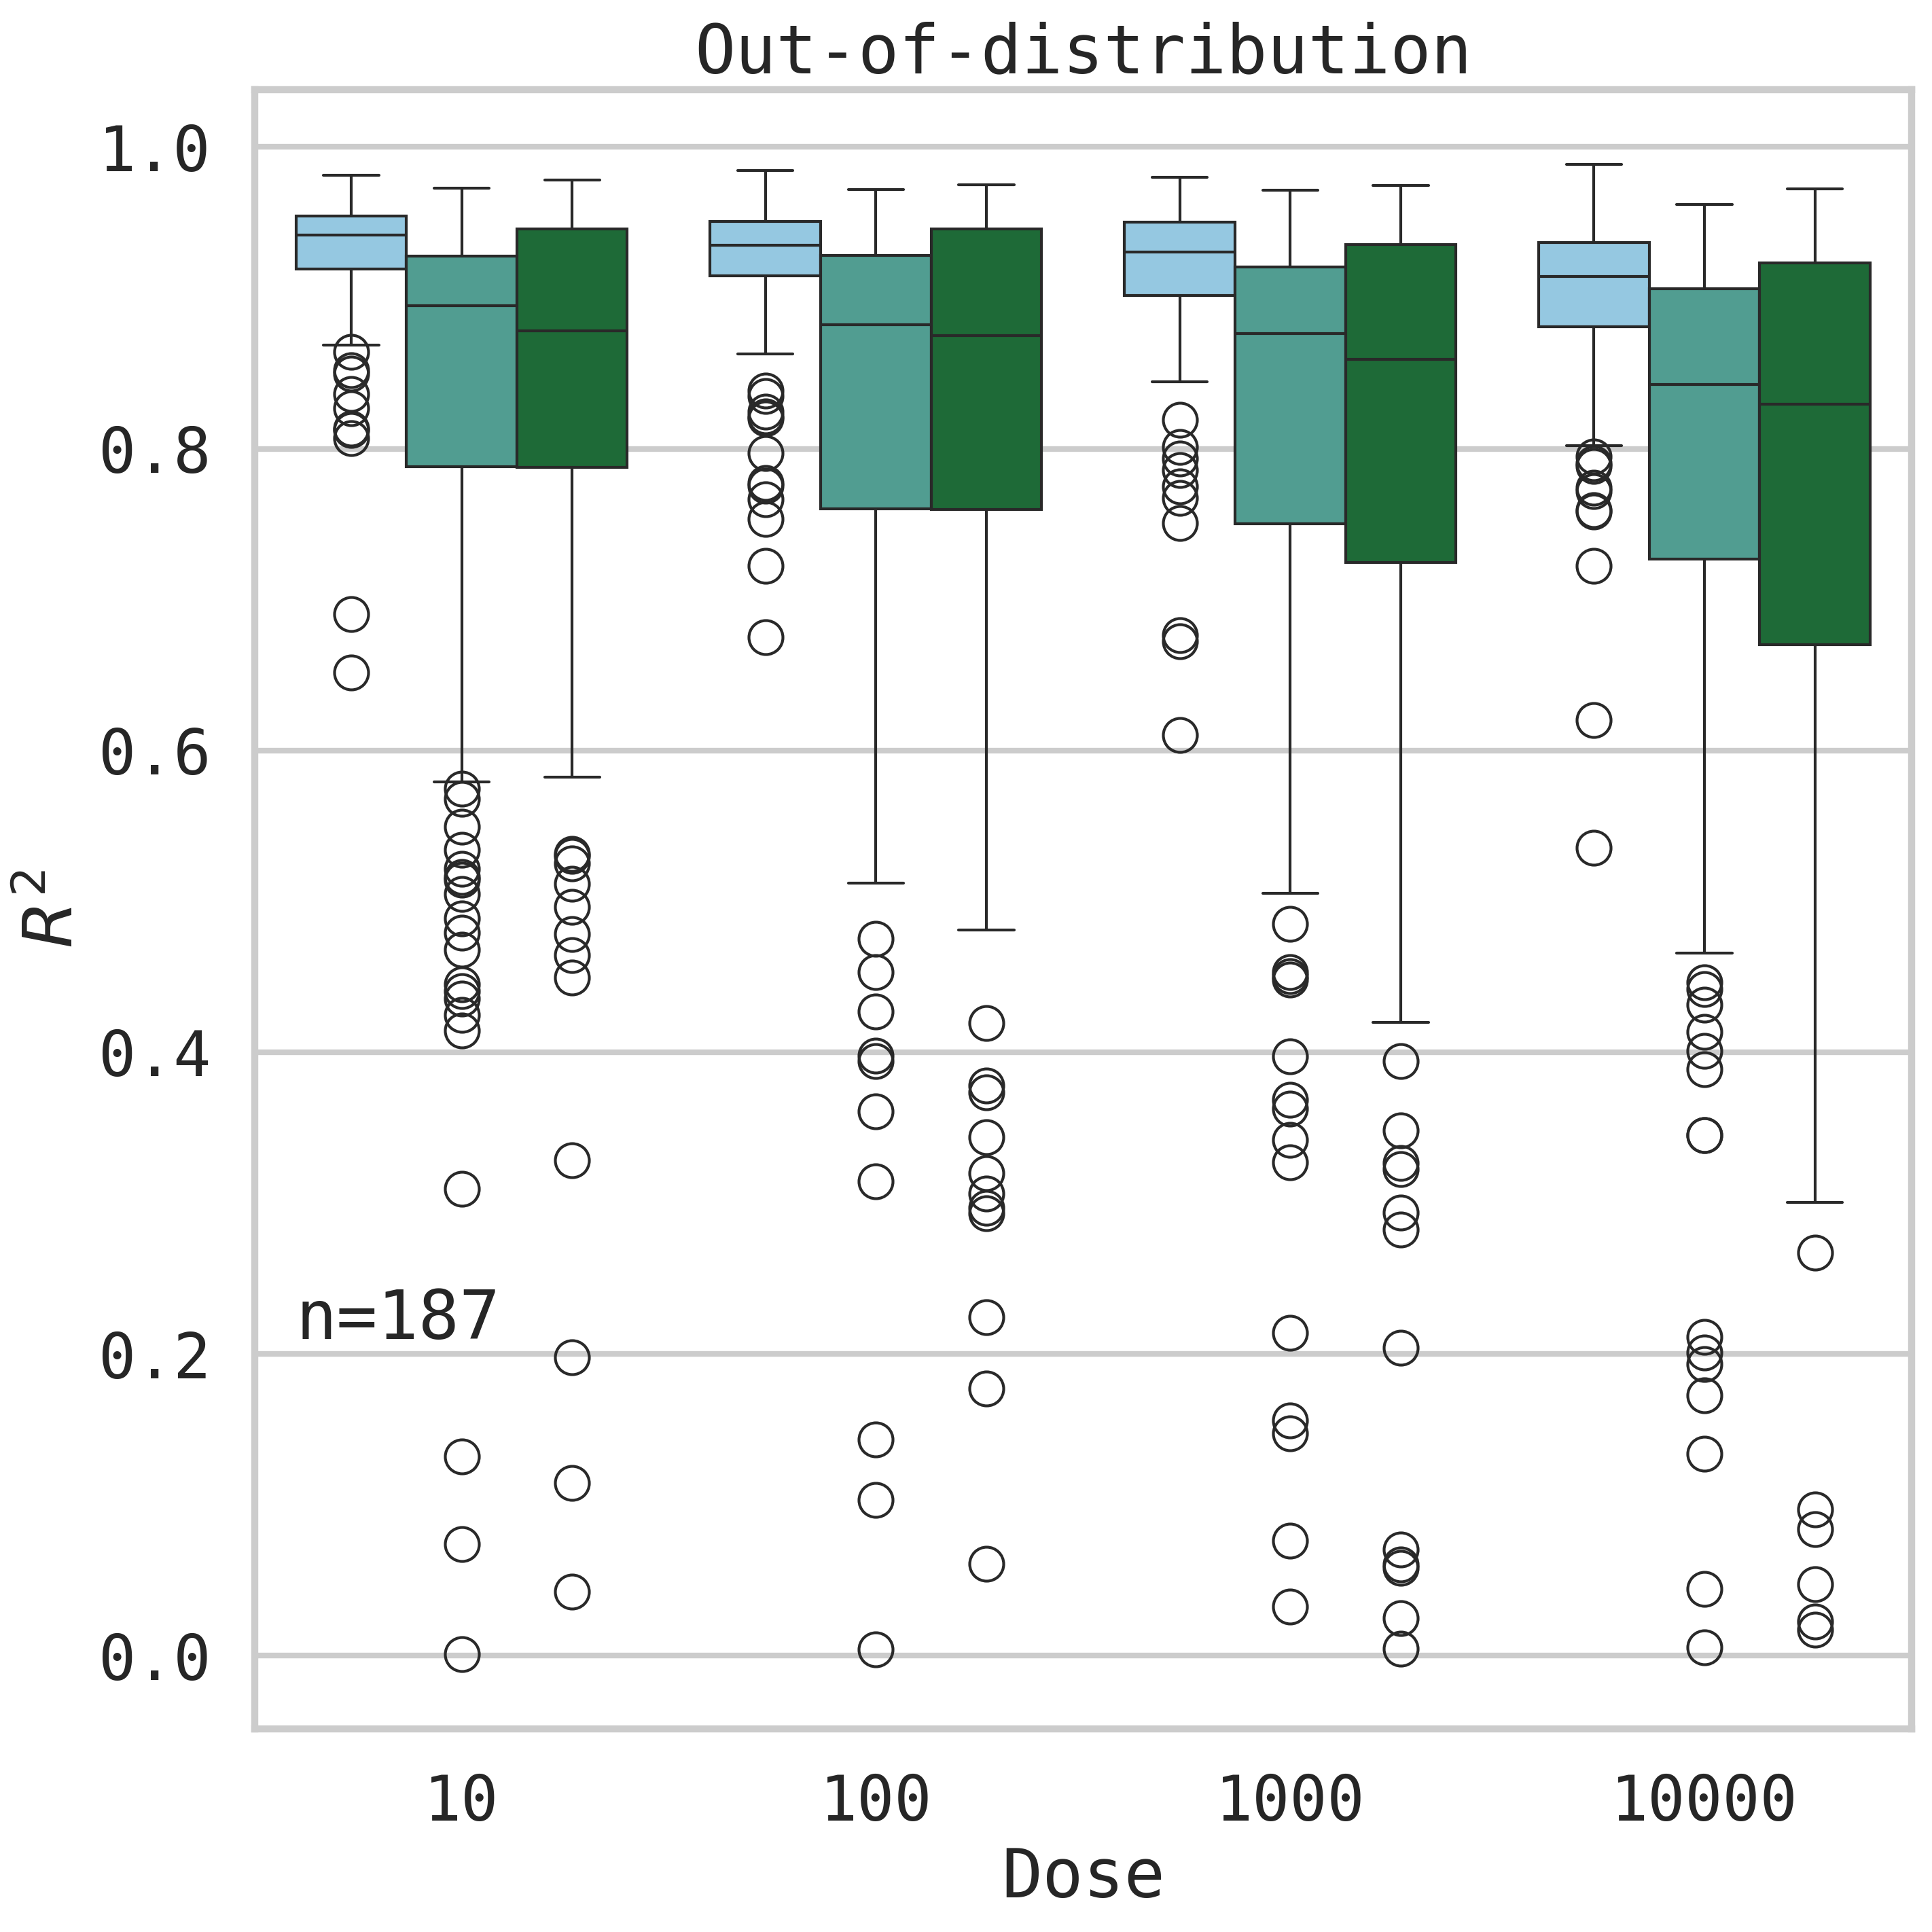

In [38]:
fig, ax = plt.subplots(figsize=(10,10))

sns.boxplot(data=big_results, x="dose", y="mean_r2", hue="model", palette=OOD_model_color_dict,
            hue_order=["CMonge-DrugDose-MoA (712 cond.)", "CMonge-DrugDose-RDkit (712 cond.)", "chemCPA (712 cond.)"], ax=ax)

# ax.plot(dose_monge["r2"],'r-o',c=OOD_model_color_dict["Monge (1 cond.)"], linewidth=3, markersize=7, label="Monge (1 cond.)")
# ax.plot(dose_identity["r2"],'r-o',c=OOD_model_color_dict["Identity"], linewidth=3, markersize=7, label="Identity")

plt.title("Out-of-distribution")
plt.ylabel("$R^2$")
plt.xlabel("Dose")

# handles, labels = ax.get_legend_handles_labels()
# order = [3,2, 0, 1]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="", ncols=2, bbox_to_anchor=(0.5, -0.2), loc="upper center")
plt.legend("", frameon=False)

plt.text(x=-0.4, y=0.21 , s="n=187")
plt.tight_layout()
plt.savefig("/Users/alicedriessen/Box/otperturb/alice_exp/figures/sciplex_large_drugdose_OOD_NoLegend.pdf", bbox_inches="tight")

## Suppl. Tables

In [39]:
big_results.groupby(["model", "dose", "embedding"]).mean(numeric_only=True)

mean_r2  mean_wasserstein  \
model                             dose  embedding                               
CMonge-DrugDose-MoA (712 cond.)   10    moa        0.930708          3.863757   
                                  100   moa        0.923775          3.873071   
                                  1000  moa        0.917369          3.877575   
                                  10000 moa        0.900322          3.825043   
CMonge-DrugDose-RDkit (712 cond.) 10    rdkit      0.821324          4.205358   
                                  100   rdkit      0.814614          4.231511   
                                  1000  rdkit      0.800761          4.244844   
                                  10000 rdkit      0.781040          4.156188   
chemCPA (712 cond.)               10    rdkit      0.836408          4.707038   
                                  100   rdkit      0.815491          4.767268   
                                  1000  rdkit      0.792260          4.811571   
                                  10000 rdkit      0.759900          4.946657   

                                                   mean_mmd  n_cond  
model                             dose  embedding                    
CMonge-DrugDose-MoA (712 cond.)   10    moa        0.011686   712.0  
                                  100   moa        0.012025   712.0  
                                  1000  moa        0.012720   712.0  
                                  10000 moa        0.013496   712.0  
CMonge-DrugDose-RDkit (712 cond.) 10    rdkit      0.017504   712.0  
                                  100   rdkit      0.018368   712.0  
                                  1000  rdkit      0.018905   712.0  
                                  10000 rdkit      0.019711   712.0  
chemCPA (712 cond.)               10    rdkit      0.185564   712.0  
                                  100   rdkit      0.187180   712.0  
                                  1000  rdkit      0.189195   712.0  
                                  10000 rdkit      0.195243   712.0

In [40]:
big_results.groupby(["model", "dose", "embedding"]).std(numeric_only=True)

mean_r2  mean_wasserstein  \
model                             dose  embedding                               
CMonge-DrugDose-MoA (712 cond.)   10    moa        0.041932          0.633114   
                                  100   moa        0.046061          0.642515   
                                  1000  moa        0.052730          0.602601   
                                  10000 moa        0.059424          0.578099   
CMonge-DrugDose-RDkit (712 cond.) 10    rdkit      0.172521          0.887274   
                                  100   rdkit      0.168257          0.895599   
                                  1000  rdkit      0.182026          0.818590   
                                  10000 rdkit      0.186812          0.746765   
chemCPA (712 cond.)               10    rdkit      0.154174          0.913377   
                                  100   rdkit      0.177977          0.975527   
                                  1000  rdkit      0.205082          1.069549   
                                  10000 rdkit      0.211152          1.271008   

                                                   mean_mmd  n_cond  
model                             dose  embedding                    
CMonge-DrugDose-MoA (712 cond.)   10    moa        0.002286     0.0  
                                  100   moa        0.002402     0.0  
                                  1000  moa        0.003018     0.0  
                                  10000 moa        0.004533     0.0  
CMonge-DrugDose-RDkit (712 cond.) 10    rdkit      0.010978     0.0  
                                  100   rdkit      0.011365     0.0  
                                  1000  rdkit      0.011174     0.0  
                                  10000 rdkit      0.011704     0.0  
chemCPA (712 cond.)               10    rdkit      0.022213     0.0  
                                  100   rdkit      0.024461     0.0  
                                  1000  rdkit      0.028888     0.0  
                                  10000 rdkit      0.034966     0.0